# Predicting Monthly Dengue Count and Intensity via Meteorlogical Conditions


## Research Hypothesis
### <li>Null Hypothesis: There is no association between Meteorlogical Factors and Monthly Dengue Count</li>
### <li>Alternate Hypothesis: There is an association between Meteorlogical Factors and Monthly Dengue Count </li>


In [2]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
%matplotlib inline 
#!pip install --user researchpy 

import researchpy as rp

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, max_error, mean_absolute_error, mean_squared_error,max_error,accuracy_score
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt

In [3]:
import MySQLdb
import pandas as pd
import numpy as np

groupvars = {}
with open("project_db") as myfile:
    for line in myfile:
        name, var = line.partition(":")[::2]
        groupvars[name.strip()] = var.strip()

conn = MySQLdb.connect(host="localhost", user=groupvars['DB username'], 
                       passwd=groupvars['DB password'], db=groupvars['DB databasename'])
cursor = conn.cursor()

In [4]:
cursor.execute('SELECT * FROM DENGUE_METEOR_COUNT;')
field_names = [i[0] for i in cursor.description]
dengue_month = cursor.fetchall()
DENGUE_METEOR = pd.DataFrame(dengue_month, columns = field_names)
#print(DENGUE_METEOR)

In [5]:
cursor.execute('SELECT * FROM DENGUE_METEOR_COUNT_TWO;')
field_names = [i[0] for i in cursor.description]
dengue_month = cursor.fetchall()
DENGUE_METEOR_TWO = pd.DataFrame(dengue_month, columns = field_names)
#print(DENGUE_METEOR_TWO)

In [6]:
cursor.execute('SELECT * FROM DENGUE_METEOR_COUNT_FOUR;')
field_names = [i[0] for i in cursor.description]
dengue_month = cursor.fetchall()
DENGUE_METEOR_FOUR = pd.DataFrame(dengue_month, columns = field_names)
#print(DENGUE_METEOR_FOUR)

In [7]:
cursor.execute('SELECT * FROM MOS_MET;')
field_names = [i[0] for i in cursor.description]
mos = cursor.fetchall()
MOS_MET = pd.DataFrame(mos, columns= field_names)
#print(MOS_MET)

## Formating Datatypes for sake of analysis

In [8]:
print(DENGUE_METEOR.dtypes)
DENGUE_METEOR.iloc[:, 6:8] = DENGUE_METEOR.iloc[:,6:8].apply(pd.to_numeric)
DENGUE_METEOR.iloc[:,-4:] = DENGUE_METEOR.iloc[:,-4:].apply(pd.to_numeric)
DENGUE_METEOR.iloc[:,2] = DENGUE_METEOR.iloc[:,2].apply(pd.to_datetime)
DENGUE_METEOR.iloc[:,5] = DENGUE_METEOR.iloc[:,5].apply(pd.to_datetime)
#print(DENGUE_METEOR.dtypes)

Unique_ID           int64
County             object
Symptoms           object
Y                   int64
M                   int64
Time               object
LATITUDE           object
LONGITUDE          object
MONTH_COUNT         int64
air_temp_max_c     object
air_temp_min_c     object
air_temp_aver_c    object
humidity           object
dtype: object


In [9]:
print(DENGUE_METEOR_TWO.dtypes)
DENGUE_METEOR_TWO.iloc[:, 6:8] = DENGUE_METEOR_TWO.iloc[:,6:8].apply(pd.to_numeric)
DENGUE_METEOR_TWO.iloc[:,-4:] = DENGUE_METEOR_TWO.iloc[:,-4:].apply(pd.to_numeric)
DENGUE_METEOR_TWO.iloc[:,2] = DENGUE_METEOR_TWO.iloc[:,2].apply(pd.to_datetime)
DENGUE_METEOR_TWO.iloc[:,5] = DENGUE_METEOR_TWO.iloc[:,5].apply(pd.to_datetime)
print(DENGUE_METEOR_TWO.dtypes)

Unique_ID           int64
County             object
Symptoms           object
Y                   int64
M                   int64
Time               object
LATITUDE           object
LONGITUDE          object
MONTH_COUNT         int64
air_temp_max_c     object
air_temp_min_c     object
air_temp_aver_c    object
humidity           object
dtype: object
Unique_ID                   int64
County                     object
Symptoms           datetime64[ns]
Y                           int64
M                           int64
Time               datetime64[ns]
LATITUDE                  float64
LONGITUDE                 float64
MONTH_COUNT                 int64
air_temp_max_c            float64
air_temp_min_c            float64
air_temp_aver_c           float64
humidity                  float64
dtype: object


In [10]:
print(DENGUE_METEOR_FOUR.dtypes)
DENGUE_METEOR_FOUR.iloc[:, 6:8] = DENGUE_METEOR_FOUR.iloc[:,6:8].apply(pd.to_numeric)
DENGUE_METEOR_FOUR.iloc[:,-4:] = DENGUE_METEOR_FOUR.iloc[:,-4:].apply(pd.to_numeric)
DENGUE_METEOR_FOUR.iloc[:,2] = DENGUE_METEOR_FOUR.iloc[:,2].apply(pd.to_datetime)
DENGUE_METEOR_FOUR.iloc[:,5] = DENGUE_METEOR_FOUR.iloc[:,5].apply(pd.to_datetime)
print(DENGUE_METEOR_FOUR.dtypes)

Unique_ID           int64
County             object
Symptoms           object
Y                   int64
M                   int64
Time               object
LATITUDE           object
LONGITUDE          object
MONTH_COUNT         int64
air_temp_max_c     object
air_temp_min_c     object
air_temp_aver_c    object
humidity           object
dtype: object
Unique_ID                   int64
County                     object
Symptoms           datetime64[ns]
Y                           int64
M                           int64
Time               datetime64[ns]
LATITUDE                  float64
LONGITUDE                 float64
MONTH_COUNT                 int64
air_temp_max_c            float64
air_temp_min_c            float64
air_temp_aver_c           float64
humidity                  float64
dtype: object


In [11]:
print(MOS_MET.dtypes)
MOS_MET.iloc[:, 2:4] = MOS_MET.iloc[:,2:4].apply(pd.to_numeric)
MOS_MET.iloc[:,-4:] = MOS_MET.iloc[:, -4:].apply(pd.to_numeric)
print(MOS_MET.dtypes)

FEMALE_COUNT     int64
GENUS           object
LATITUDE        object
LONGITUDE       object
COUNTY          object
TEMP_MAX        object
TEMP_MIN        object
TEMP_AVER       object
HUMIDITY        object
dtype: object
FEMALE_COUNT      int64
GENUS            object
LATITUDE        float64
LONGITUDE       float64
COUNTY           object
TEMP_MAX        float64
TEMP_MIN        float64
TEMP_AVER       float64
HUMIDITY        float64
dtype: object


In [12]:
MOS_MET = MOS_MET[MOS_MET['GENUS'] == 'Aedes']
print(len(MOS_MET))

x_std = np.std(MOS_MET['FEMALE_COUNT'])
x_mean = np.mean(MOS_MET['FEMALE_COUNT'])

MOS_MET = MOS_MET[MOS_MET['FEMALE_COUNT'] <= x_mean + 4*x_std]
MOS_MET = MOS_MET[MOS_MET['FEMALE_COUNT'] >= x_mean - 4*x_std]

print(len(MOS_MET))

251
248


### Statistical Testing for Variables

In [13]:
import matplotlib.pyplot as plt
import numpy as np
dengue_count_df = pd.read_sql("SELECT * FROM DENGUE_TWO_AVER;",con=conn)
dengue_count_df["MONTH"] = dengue_count_df['YEAR(Symptoms)'].astype(str) +" "+ dengue_count_df['MONTHNAME(Symptoms)']
del dengue_count_df['YEAR(Symptoms)']
del dengue_count_df['MONTHNAME(Symptoms)']
#Converting the month column from string to date time
dengue_count_df['MONTH']=pd.to_datetime(dengue_count_df['MONTH'])
dengue_count_df.head(5)

,DENGUE_COUNT,AVER_MAX,AVER_MIN,AVER_AVER,AVER_HUMIDITY,MONTH
0,11,27.482955,19.545455,23.784091,78.346591,2015-01-01
1,19,26.697368,20.884868,23.342105,85.424342,2015-02-01
2,4,27.812500,23.250000,25.375000,78.187500,2015-03-01
3,8,26.703125,20.710938,23.507812,82.046875,2015-04-01
4,5,27.037500,20.387500,23.687500,80.000000,2015-05-01


In [14]:
dengue_count_df = dengue_count_df.astype('category')
wd_column = dengue_count_df.select_dtypes(['category']).columns
dengue_count_df[wd_column] = dengue_count_df[wd_column].apply(lambda x: x.cat.codes)
print(dengue_count_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   DENGUE_COUNT   75 non-null     int8 
 1   AVER_MAX       75 non-null     int8 
 2   AVER_MIN       75 non-null     int8 
 3   AVER_AVER      75 non-null     int8 
 4   AVER_HUMIDITY  75 non-null     int8 
 5   MONTH          75 non-null     int8 
dtypes: int8(6)
memory usage: 578.0 bytes
None


array([[<AxesSubplot:title={'center':'DENGUE_COUNT'}>]], dtype=object)

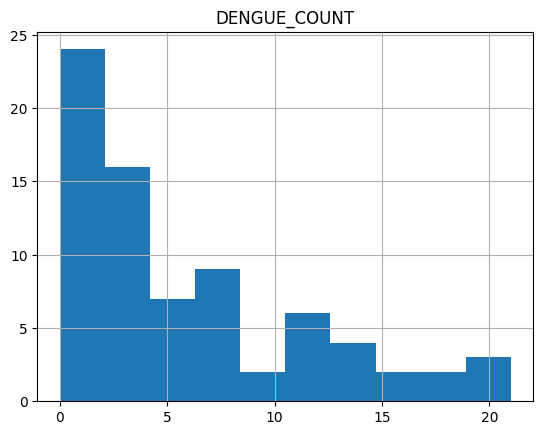

In [15]:
dengue_count_df.hist(column='DENGUE_COUNT')

In [16]:
#Normaliy Testing
from scipy.stats import normaltest

stats, p = normaltest(dengue_count_df)
print('Statistics = %.3f, p = %.3f' % (stats.all(), p.all()))
# interpret results
alpha = 0.05
if p.all() > alpha:
    print('Dengue data looks Gaussian ')
else:
    print('Dengue data does not look Gaussian ')

Statistics = 1.000, p = 1.000
Dengue data looks Gaussian 


In [17]:
import scipy
#PEARSON CORRELATION
a=dengue_count_df['DENGUE_COUNT']
x=dengue_count_df['AVER_MAX']
y=dengue_count_df['AVER_MIN']
z=dengue_count_df['AVER_AVER']
b=dengue_count_df['AVER_HUMIDITY']

In [18]:
maxtemp_dengue=scipy.stats.pearsonr(a,x)
maxtemp_dengue

PearsonRResult(statistic=0.1811041345114239, pvalue=0.11995713787898706)

In [19]:
mintemp_dengue=scipy.stats.pearsonr(a,y)
mintemp_dengue

PearsonRResult(statistic=-0.036851429352620334, pvalue=0.7536052865895588)

In [20]:
avgtemp_dengue=scipy.stats.pearsonr(a,z)
avgtemp_dengue

PearsonRResult(statistic=0.12918810206421652, pvalue=0.2693125302100708)

In [21]:
humidity_dengue=scipy.stats.pearsonr(a,b)
humidity_dengue

PearsonRResult(statistic=0.04366675998758727, pvalue=0.7098994656772776)

In [22]:
NullHypothesis='There is no association between meteorological conditions and Dengue cases, and such conditions cannot be used to predict Dengue case counts'
p=0.25
if p<0.05:
    print("Reject", NullHypothesis)
else:
    print("Fail to Reject Null Hypothesis", NullHypothesis)

Fail to Reject Null Hypothesis There is no association between meteorological conditions and Dengue cases, and such conditions cannot be used to predict Dengue case counts


### Show distributions of Mosquito Counts to show is Poison in distribution

(array([ 73., 128.,  28.,   8.,   4.,   4.,   3.,   0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <BarContainer object of 8 artists>)

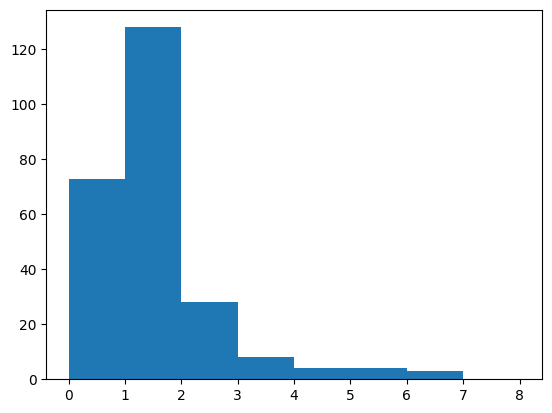

In [23]:
import matplotlib.pyplot as plt

plt.hist(MOS_MET['FEMALE_COUNT'], bins = [0,1,2,3,4,5,6,7,8])

In [24]:
MOS_MET.describe()


,FEMALE_COUNT,LATITUDE,LONGITUDE,TEMP_MAX,TEMP_MIN,TEMP_AVER,HUMIDITY
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,1.056452,2.458773,-76.580123,26.146673,20.770413,23.067792,86.775706
std,1.115242,0.748184,0.363985,1.651749,0.778317,0.894371,2.741066
min,0.000000,1.112719,-76.985833,22.250000,19.375000,20.812500,82.312500
25%,0.000000,2.110242,-76.982546,24.875000,20.250000,22.500000,84.312500
50%,1.000000,2.115323,-76.329451,25.468750,20.812500,22.750000,87.250000
75%,1.000000,3.251478,-76.231790,27.562500,21.250000,23.687500,88.531250
max,6.000000,3.260237,-76.226519,28.750000,22.625000,24.437500,92.312500


(array([78., 92., 88., 74., 89., 19., 20., 23., 27., 62.]),
 array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ]),
 <BarContainer object of 10 artists>)

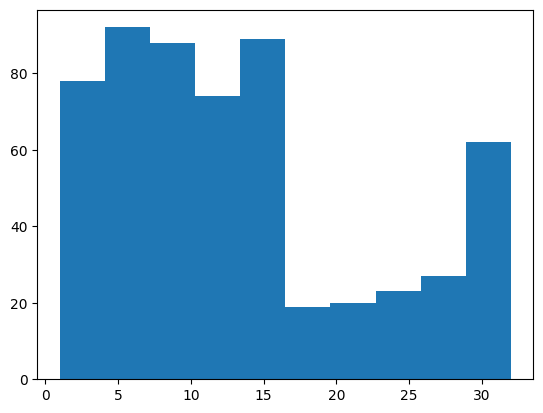

In [25]:
plt.hist(DENGUE_METEOR['MONTH_COUNT'])

In [26]:
DENGUE_METEOR.describe()

,Unique_ID,Y,M,LATITUDE,LONGITUDE,MONTH_COUNT,air_temp_max_c,air_temp_min_c,air_temp_aver_c,humidity
count,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000
mean,286.500000,2017.900350,5.426573,2.129247,-76.541116,13.520979,27.906578,20.954218,24.236014,82.541302
std,165.266452,2.100504,3.704004,0.854740,0.352537,8.773742,2.006245,1.550609,1.296991,6.115039
min,1.000000,2015.000000,1.000000,0.984080,-77.157079,1.000000,22.375000,15.625000,19.187500,54.625000
25%,143.750000,2016.000000,2.000000,1.119409,-76.982139,7.000000,26.562500,20.187500,23.375000,78.656250
50%,286.500000,2018.000000,4.500000,2.112745,-76.327715,12.000000,27.906250,21.062500,24.187500,83.312500
75%,429.250000,2020.000000,9.000000,3.248863,-76.231968,19.000000,29.062500,21.812500,24.937500,87.203125
max,572.000000,2021.000000,12.000000,3.270120,-76.131115,32.000000,37.125000,25.875000,29.125000,95.625000


(array([258., 116.,  47.,  39.,   0.,  23.,   0.,  27.,  30.,  32.]),
 array([1.000e+00, 1.033e+02, 2.056e+02, 3.079e+02, 4.102e+02, 5.125e+02,
        6.148e+02, 7.171e+02, 8.194e+02, 9.217e+02, 1.024e+03]),
 <BarContainer object of 10 artists>)

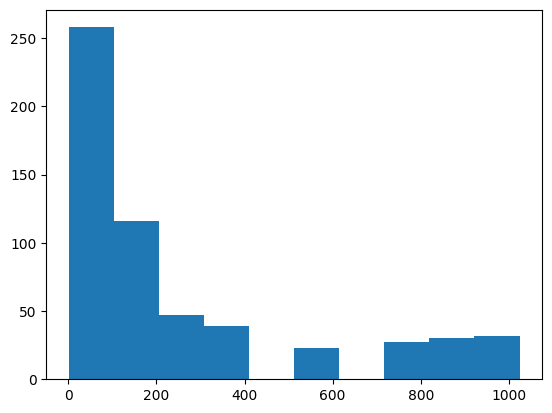

In [27]:
plt.hist(DENGUE_METEOR['MONTH_COUNT']**2)
#for sake of variance stablization

## Because of faults in Mosquito Data, appending to proper NC-Meteorlogical Data cannot be done. Therefore, instead we will train based on the varying latitude/longitude of the Specimen Collection locations, and then extrapolate such a models data via the latitude/longitude of the Dengue Cases to create associated Mosquito Counts for each case.

In [28]:
print(MOS_MET[['FEMALE_COUNT','LATITUDE', 'LONGITUDE']].corr())
print(MOS_MET[['FEMALE_COUNT', 'LATITUDE', 'LONGITUDE']].cov())

print(MOS_MET[['FEMALE_COUNT', 'TEMP_MAX', 'TEMP_MIN', 'TEMP_AVER', 'HUMIDITY']].corr())

              FEMALE_COUNT  LATITUDE  LONGITUDE
FEMALE_COUNT      1.000000  0.088891   0.031511
LATITUDE          0.088891  1.000000   0.492713
LONGITUDE         0.031511  0.492713   1.000000
              FEMALE_COUNT  LATITUDE  LONGITUDE
FEMALE_COUNT      1.243764  0.074171   0.012791
LATITUDE          0.074171  0.559779   0.134179
LONGITUDE         0.012791  0.134179   0.132485
              FEMALE_COUNT  TEMP_MAX  TEMP_MIN  TEMP_AVER  HUMIDITY
FEMALE_COUNT      1.000000 -0.019760  0.086412  -0.003091 -0.001967
TEMP_MAX         -0.019760  1.000000  0.321084   0.918453 -0.564468
TEMP_MIN          0.086412  0.321084  1.000000   0.556073 -0.011322
TEMP_AVER        -0.003091  0.918453  0.556073   1.000000 -0.361420
HUMIDITY         -0.001967 -0.564468 -0.011322  -0.361420  1.000000


In [29]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.linear_model import PoissonRegressor
from sklearn import metrics

x = MOS_MET.iloc[:,2:4].values
y = MOS_MET.iloc[:, 0].values

sc_x = StandardScaler()
sc_y = StandardScaler()

sc_x = sc_x.fit_transform(x)
sc_y = np.squeeze(sc_y.fit_transform(y.reshape(-1, 1)))


clf = PoissonRegressor()
kf = KFold(n_splits = 10, random_state = 1, shuffle = True)
scores = cross_validate(clf, x, y, scoring = ('r2','neg_mean_squared_error'), cv = kf, n_jobs = 1)
#print(scores)
print('Poisson Average 10-fold r^2 model value:', np.mean(scores['test_r2']))
print('Poisson Average 10-fold mean_squared_error:', abs(np.mean(scores['test_neg_mean_squared_error'])), '\n')


regressor = SVR(kernel = 'rbf')
kf = KFold(n_splits = 10, random_state = 1, shuffle = True)

scores = cross_validate(regressor, sc_x, sc_y, scoring = ('r2' ,'neg_mean_squared_error'), cv = kf, n_jobs = 1)
#print(scores)
print('SVR Average 10-fold r^2 model value:', np.mean(scores['test_r2']))
print('SVR Average 10-fold mean_squared_error:', abs(np.mean(scores['test_neg_mean_squared_error'])), '\n')

clf = PoissonRegressor()
regressor = SVR(kernel = 'rbf')
clf.fit(x,y)
regressor.fit(sc_x, sc_y)
print(clf.score(x,y))
print(metrics.mean_squared_error(y, clf.predict(x)))
print(regressor.score(sc_x, sc_y))
print(metrics.mean_squared_error(sc_y, regressor.predict(sc_x)))

Poisson Average 10-fold r^2 model value: -0.041179542338838124
Poisson Average 10-fold mean_squared_error: 1.2486077635077266 

SVR Average 10-fold r^2 model value: -0.05104209839064557
SVR Average 10-fold mean_squared_error: 1.0262949384695481 

0.005073173973573986
1.232859316712488
-0.022651436133509062
1.0226514361335093


In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.graphics.api import abline_plot
x = MOS_MET.iloc[:, 2:4]
y = MOS_MET.iloc[:, 0]
x = sm.add_constant(x, prepend = False)

glm_pois = sm.GLM(y,x, family = sm.families.Poisson())
res = glm_pois.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           FEMALE_COUNT   No. Observations:                  248
Model:                            GLM   Df Residuals:                      245
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -331.74
Date:                Tue, 13 Dec 2022   Deviance:                       272.41
Time:                        20:22:50   Pearson chi2:                     290.
No. Iterations:                     5   Pseudo R-squ. (CS):           0.009731
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LATITUDE       0.1460      0.103      1.414      0.1

## Choosen extrapolation function: GLM

572
572


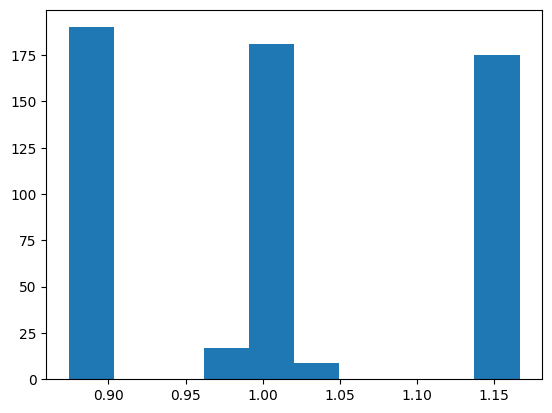

In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.graphics.api import abline_plot
x = MOS_MET.iloc[:, 2:4]
y = MOS_MET.iloc[:, 0]


glm_pois = sm.GLM(y,x, family = sm.families.Poisson())
res = glm_pois.fit()
res.summary()

extrap_mos = res.predict(DENGUE_METEOR.iloc[:, 6:8])
plt.hist(extrap_mos)
print(len(extrap_mos))
print(len(DENGUE_METEOR))

## Now predict mosquitos to each Dengue case upon immediate conditions (or current mosquitos), 2-weeks prior (or number of mosquitoes at time of bite), and 4-weeks-prior (or at gestation time of mosquitos)

In [32]:
DENGUE_METEOR['mos'] = res.predict(DENGUE_METEOR.iloc[:, 6:8])
DENGUE_METEOR_TWO['mos'] = res.predict(DENGUE_METEOR_TWO.iloc[:, 6:8])
DENGUE_METEOR_FOUR['mos'] = res.predict(DENGUE_METEOR_FOUR.iloc[:, 6:8])

In [33]:
DENGUE_METEOR.head()

,Unique_ID,County,Symptoms,Y,M,Time,LATITUDE,LONGITUDE,MONTH_COUNT,air_temp_max_c,air_temp_min_c,air_temp_aver_c,humidity,mos
0,1,Piamonte,2018-01-24,2018,1,2018-01-24,1.119479,-76.329537,5,26.8125,17.0625,22.3125,82.3750,0.889049
1,2,Piamonte,2016-01-07,2016,1,2016-01-07,0.984080,-76.273166,30,32.1250,23.1250,26.9375,86.1250,0.874156
2,3,Piamonte,2018-02-08,2018,2,2018-02-08,1.119409,-76.327719,14,29.0625,23.0000,25.6875,77.3750,0.889047
3,4,Piamonte,2018-02-10,2018,2,2018-02-10,1.119479,-76.329537,14,32.7500,20.8750,26.2500,65.3750,0.889049
4,5,Piamonte,2018-02-07,2018,2,2018-02-07,1.119409,-76.327719,14,30.8125,21.6250,25.4375,79.3125,0.889047


In [34]:
DENGUE_METEOR_TWO.head()

,Unique_ID,County,Symptoms,Y,M,Time,LATITUDE,LONGITUDE,MONTH_COUNT,air_temp_max_c,air_temp_min_c,air_temp_aver_c,humidity,mos
0,1,Piamonte,2018-01-24,2018,1,2018-01-10,1.119479,-76.329537,5,25.4375,20.0000,22.6875,89.8125,0.889049
1,2,Piamonte,2016-01-07,2016,1,2015-12-24,0.984080,-76.273166,30,30.5625,21.8750,26.7500,81.8750,0.874156
2,3,Piamonte,2018-02-08,2018,2,2018-01-25,1.119409,-76.327719,14,26.8125,18.0625,22.5000,85.8750,0.889047
3,4,Piamonte,2018-02-10,2018,2,2018-01-27,1.119479,-76.329537,14,27.1250,19.2500,23.2500,87.0625,0.889049
4,5,Piamonte,2018-02-07,2018,2,2018-01-24,1.119409,-76.327719,14,26.8125,17.0625,22.3125,82.3750,0.889047


In [35]:
DENGUE_METEOR_FOUR.head()

,Unique_ID,County,Symptoms,Y,M,Time,LATITUDE,LONGITUDE,MONTH_COUNT,air_temp_max_c,air_temp_min_c,air_temp_aver_c,humidity,mos
0,1,Piamonte,2018-01-24,2018,1,2017-12-27,1.119479,-76.329537,5,28.8750,20.6875,24.1875,86.7500,0.889049
1,2,Piamonte,2016-01-07,2016,1,2015-12-10,0.984080,-76.273166,30,28.7500,23.1875,25.7500,88.1875,0.874156
2,3,Piamonte,2018-02-08,2018,2,2018-01-11,1.119409,-76.327719,14,24.7500,19.0625,21.9375,91.5000,0.889047
3,4,Piamonte,2018-02-10,2018,2,2018-01-13,1.119479,-76.329537,14,27.6875,19.9375,23.2500,89.6875,0.889049
4,5,Piamonte,2018-02-07,2018,2,2018-01-10,1.119409,-76.327719,14,25.4375,20.0000,22.6875,89.8125,0.889047


# Show correlation/covariance of all elements to show how meteorlogical conditions correlate with mosquiotes and Dengue Count, and how Dengue Count correlates with Mosquito Count

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

relevant_variables = ['MONTH_COUNT', 'mos', 'LATITUDE', 'LONGITUDE', \
                       'air_temp_max_c', 'air_temp_min_c', 'air_temp_aver_c', 'humidity']
DENGUE_METEOR[relevant_variables].corr()

,MONTH_COUNT,mos,LATITUDE,LONGITUDE,air_temp_max_c,air_temp_min_c,air_temp_aver_c,humidity
MONTH_COUNT,1.000000,-0.096371,-0.092890,-0.078723,0.161804,0.037285,0.171174,0.049463
mos,-0.096371,1.000000,0.998707,0.175723,-0.220629,-0.045147,-0.080135,-0.323985
LATITUDE,-0.092890,0.998707,1.000000,0.125662,-0.203087,-0.031635,-0.060325,-0.332631
LONGITUDE,-0.078723,0.175723,0.125662,1.000000,-0.386930,-0.276484,-0.408752,0.121682
air_temp_max_c,0.161804,-0.220629,-0.203087,-0.386930,1.000000,0.253270,0.837394,-0.528721
air_temp_min_c,0.037285,-0.045147,-0.031635,-0.276484,0.253270,1.000000,0.651722,-0.041699
air_temp_aver_c,0.171174,-0.080135,-0.060325,-0.408752,0.837394,0.651722,1.000000,-0.512185
humidity,0.049463,-0.323985,-0.332631,0.121682,-0.528721,-0.041699,-0.512185,1.000000


In [37]:
DENGUE_METEOR.describe()

,Unique_ID,Y,M,LATITUDE,LONGITUDE,MONTH_COUNT,air_temp_max_c,air_temp_min_c,air_temp_aver_c,humidity,mos
count,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000
mean,286.500000,2017.900350,5.426573,2.129247,-76.541116,13.520979,27.906578,20.954218,24.236014,82.541302,1.015057
std,165.266452,2.100504,3.704004,0.854740,0.352537,8.773742,2.006245,1.550609,1.296991,6.115039,0.110398
min,1.000000,2015.000000,1.000000,0.984080,-77.157079,1.000000,22.375000,15.625000,19.187500,54.625000,0.874156
25%,143.750000,2016.000000,2.000000,1.119409,-76.982139,7.000000,26.562500,20.187500,23.375000,78.656250,0.889047
50%,286.500000,2018.000000,4.500000,2.112745,-76.327715,12.000000,27.906250,21.062500,24.187500,83.312500,1.005539
75%,429.250000,2020.000000,9.000000,3.248863,-76.231968,19.000000,29.062500,21.812500,24.937500,87.203125,1.163487
max,572.000000,2021.000000,12.000000,3.270120,-76.131115,32.000000,37.125000,25.875000,29.125000,95.625000,1.166645


<AxesSubplot:>

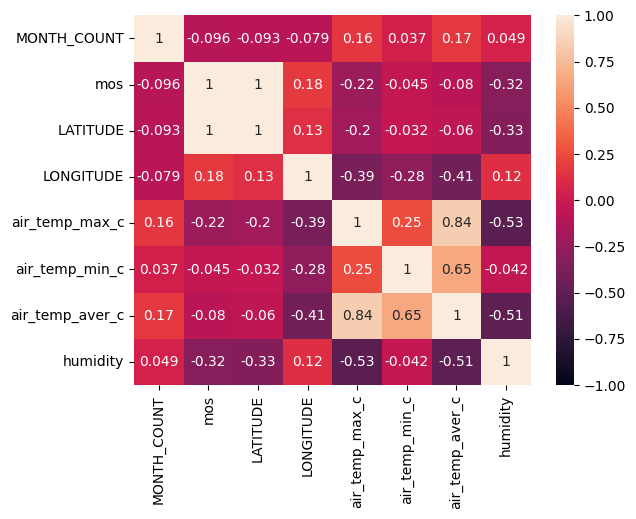

In [38]:
sns.heatmap(DENGUE_METEOR[relevant_variables].corr(), vmin = -1, vmax = 1, annot= True)
#sns.heatmap()

<AxesSubplot:>

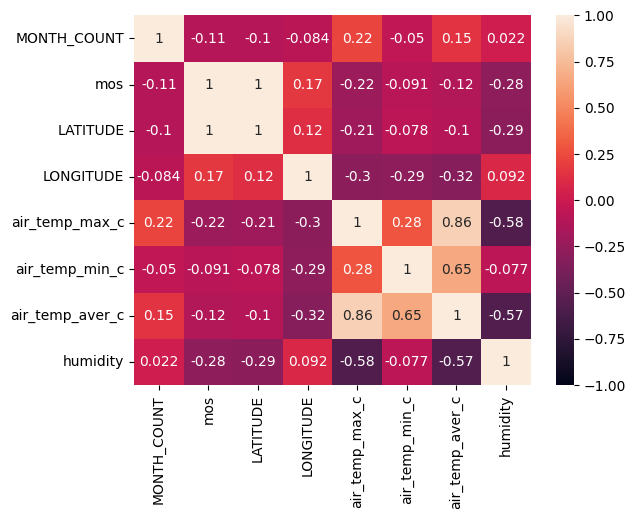

In [39]:
sns.heatmap(DENGUE_METEOR_TWO[relevant_variables].corr(), vmin = -1, vmax = 1, annot= True)

<AxesSubplot:>

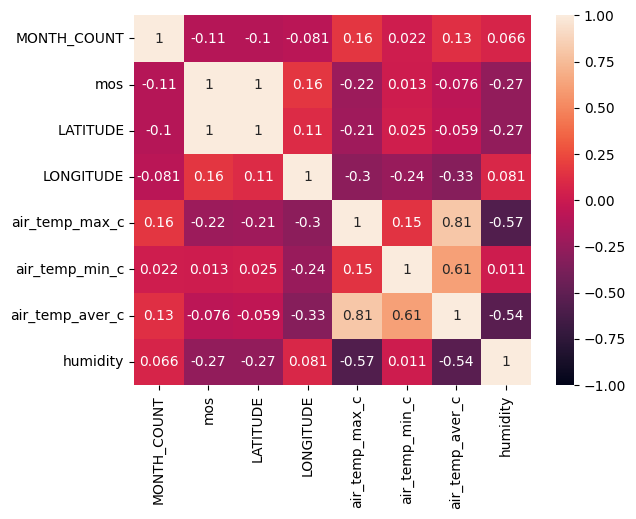

In [40]:
sns.heatmap(DENGUE_METEOR_FOUR[relevant_variables].corr(), vmin = -1, vmax = 1, annot= True)

Coefficients for the IV [air_temp_max_c, air_temp_min_c, air_temp_aver_c, humidity] are:
 [-0.04501409 -0.00856639  0.03383897 -0.01007197]
Intercept for Linear Model is: 2.4619806092827297
R^2 value of linear model for Meteorlogical conditions is: 0.33480486274487586
Mean absolute error of prediction is: 0.07470048924564004
Mean absolute percentage error is: 0.07427119011723855


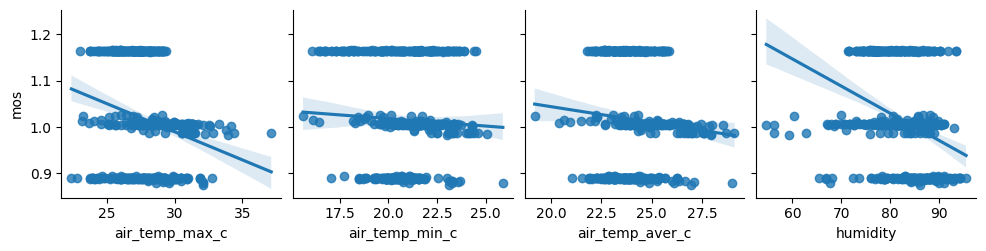

In [41]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as skm

x = DENGUE_METEOR.iloc[:,-5:-1]
y = DENGUE_METEOR['mos']

lm_mos = LinearRegression()
lm_mos.fit(x,y)
predicted_mos = lm_mos.predict(x)

print('Coefficients for the IV [air_temp_max_c, air_temp_min_c, air_temp_aver_c, humidity] are:\n', lm_mos.coef_)
print('Intercept for Linear Model is:', lm_mos.intercept_)
print('R^2 value of linear model for Meteorlogical conditions is:', lm_mos.score(x,y))
print('Mean absolute error of prediction is:', skm.mean_absolute_error(y, predicted_mos))
print('Mean absolute percentage error is:', skm.mean_absolute_percentage_error(y, predicted_mos))

sns.pairplot(DENGUE_METEOR, x_vars = ['air_temp_max_c','air_temp_min_c','air_temp_aver_c','humidity'],\
             y_vars='mos', kind = 'reg')

Coefficients for the IV [air_temp_max_c, air_temp_min_c, air_temp_aver_c, humidity] are:
 [-0.03881013 -0.00374344  0.01484335 -0.01009269]
Intercept for Linear Model is: 2.651825226665342
R^2 value of linear model for Meteorlogical conditions is: 0.31310347187146936
Mean absolute error of prediction is: 0.07648064025241524
Mean absolute percentage error is: 0.07603705247175534


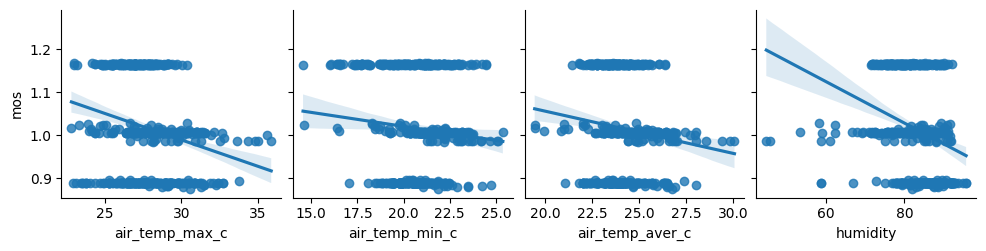

In [42]:
x = DENGUE_METEOR_TWO.iloc[:,-5:-1]
y = DENGUE_METEOR_TWO['mos']

lm_mos = LinearRegression()
lm_mos.fit(x,y)
predicted_mos = lm_mos.predict(x)

print('Coefficients for the IV [air_temp_max_c, air_temp_min_c, air_temp_aver_c, humidity] are:\n', lm_mos.coef_)
print('Intercept for Linear Model is:', lm_mos.intercept_)
print('R^2 value of linear model for Meteorlogical conditions is:', lm_mos.score(x,y))
print('Mean absolute error of prediction is:', skm.mean_absolute_error(y, predicted_mos))
print('Mean absolute percentage error is:', skm.mean_absolute_percentage_error(y, predicted_mos))

sns.pairplot(DENGUE_METEOR_TWO, x_vars = ['air_temp_max_c','air_temp_min_c','air_temp_aver_c','humidity'],\
             y_vars='mos', kind = 'reg')

Coefficients for the IV [air_temp_max_c, air_temp_min_c, air_temp_aver_c, humidity] are:
 [-0.03527703  0.00422593  0.00713434 -0.01004641]
Intercept for Linear Model is: 2.568545128476853
R^2 value of linear model for Meteorlogical conditions is: 0.28721082084092864
Mean absolute error of prediction is: 0.07740570697435908
Mean absolute percentage error is: 0.07692401702649065


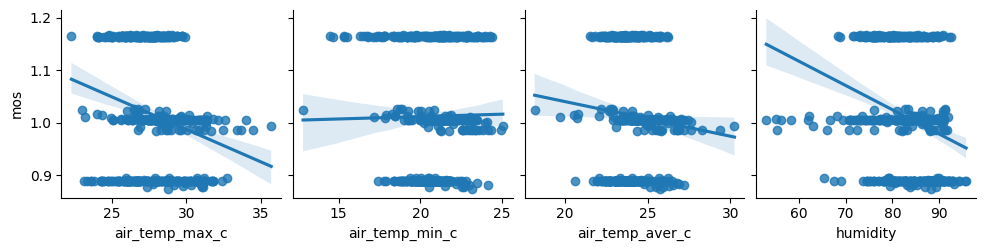

In [43]:
x = DENGUE_METEOR_FOUR.iloc[:,-5:-1]
y = DENGUE_METEOR_FOUR['mos']

lm_mos = LinearRegression()
lm_mos.fit(x,y)
predicted_mos = lm_mos.predict(x)

print('Coefficients for the IV [air_temp_max_c, air_temp_min_c, air_temp_aver_c, humidity] are:\n', lm_mos.coef_)
print('Intercept for Linear Model is:', lm_mos.intercept_)
print('R^2 value of linear model for Meteorlogical conditions is:', lm_mos.score(x,y))
print('Mean absolute error of prediction is:', skm.mean_absolute_error(y, predicted_mos))
print('Mean absolute percentage error is:', skm.mean_absolute_percentage_error(y, predicted_mos))

sns.pairplot(DENGUE_METEOR_FOUR, x_vars = ['air_temp_max_c','air_temp_min_c','air_temp_aver_c','humidity'],\
             y_vars='mos', kind = 'reg')


# Now see how Mosquitoes at each case can predict Dengue Monthly Count and with linear-model predicted mosquitoes

In [44]:
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.graphics.api import abline_plot

x = DENGUE_METEOR['mos'].values
y = DENGUE_METEOR['MONTH_COUNT'].values
x = sm.add_constant(x, prepend = False)

glm_pois = sm.GLM(y,x, family = sm.families.Poisson())
res = glm_pois.fit()
print(res.summary())
y_pred = res.predict(x)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  572
Model:                            GLM   Df Residuals:                      570
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2793.2
Date:                Tue, 13 Dec 2022   Deviance:                       3173.5
Time:                        20:22:53   Pearson chi2:                 3.23e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05171
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5715      0.104     -5.492      0.0

Mean absolute error of prediction is: 7.002447425423353
Mean absolute percentage error is: 1.0263792694668017
                 Generalized Linear Model Regression Results                  
Dep. Variable:            MONTH_COUNT   No. Observations:                  572
Model:                            GLM   Df Residuals:                      570
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2762.9
Date:                Tue, 13 Dec 2022   Deviance:                       3112.9
Time:                        20:22:53   Pearson chi2:                 3.17e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1471
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

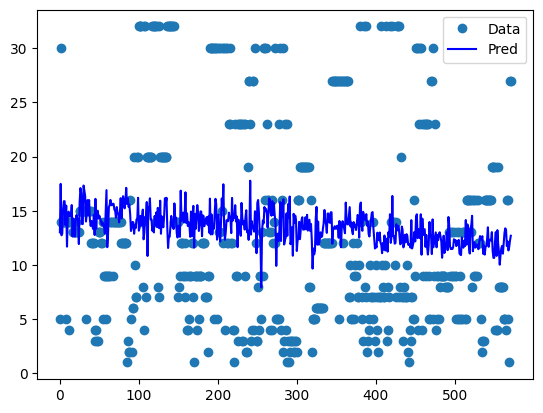

In [45]:
x = DENGUE_METEOR.iloc[:,-5:-1]
y = DENGUE_METEOR['mos']

lm_mos = LinearRegression()
lm_mos.fit(x,y)
predicted_mos = lm_mos.predict(x)
predicted_mos = sm.add_constant(predicted_mos, prepend = False)

glm_pois = sm.GLM(DENGUE_METEOR['MONTH_COUNT'], predicted_mos, family = sm.families.Poisson())
res = glm_pois.fit()
y_pred = res.predict(predicted_mos)
print('Mean absolute error of prediction is:', skm.mean_absolute_error(DENGUE_METEOR['MONTH_COUNT'], y_pred))
print('Mean absolute percentage error is:', skm.mean_absolute_percentage_error(DENGUE_METEOR['MONTH_COUNT'], y_pred))
print(res.summary())

fig, ax = plt.subplots()
ax.plot(DENGUE_METEOR['MONTH_COUNT'], "o", label="Data")
ax.plot(y_pred, "b-", label="Pred")
ax.legend(loc="best")
##Remeber the square count correction

Mean absolute error of prediction is: 6.786435540810117
Mean absolute percentage error is: 0.9905918773992103
                 Generalized Linear Model Regression Results                  
Dep. Variable:            MONTH_COUNT   No. Observations:                  567
Model:                            GLM   Df Residuals:                      565
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2683.9
Date:                Tue, 13 Dec 2022   Deviance:                       2982.0
Time:                        20:22:53   Pearson chi2:                 3.08e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3215
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

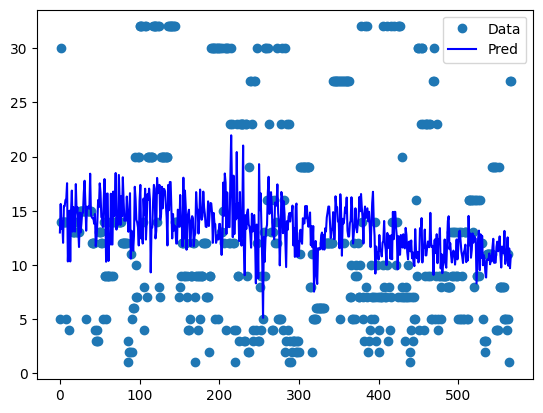

In [46]:
x = DENGUE_METEOR_TWO.iloc[:,-5:-1]
y = DENGUE_METEOR_TWO['mos']

lm_mos = LinearRegression()
lm_mos.fit(x,y)
predicted_mos = lm_mos.predict(x)
predicted_mos = sm.add_constant(predicted_mos, prepend = False)

glm_pois = sm.GLM(DENGUE_METEOR_TWO['MONTH_COUNT'], predicted_mos, family = sm.families.Poisson())
res = glm_pois.fit()
y_pred = res.predict(predicted_mos)
print('Mean absolute error of prediction is:', skm.mean_absolute_error(DENGUE_METEOR_TWO['MONTH_COUNT'], y_pred))
print('Mean absolute percentage error is:', skm.mean_absolute_percentage_error(DENGUE_METEOR_TWO['MONTH_COUNT'], y_pred))
print(res.summary())

fig, ax = plt.subplots()
ax.plot(DENGUE_METEOR_TWO['MONTH_COUNT'], "o", label="Data")
ax.plot(y_pred, "b-", label="Pred")
ax.legend(loc="best")

Mean absolute error of prediction is: 6.97568143952888
Mean absolute percentage error is: 1.0242066781253867
                 Generalized Linear Model Regression Results                  
Dep. Variable:            MONTH_COUNT   No. Observations:                  558
Model:                            GLM   Df Residuals:                      556
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2695.5
Date:                Tue, 13 Dec 2022   Deviance:                       3046.8
Time:                        20:22:53   Pearson chi2:                 3.14e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2763
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

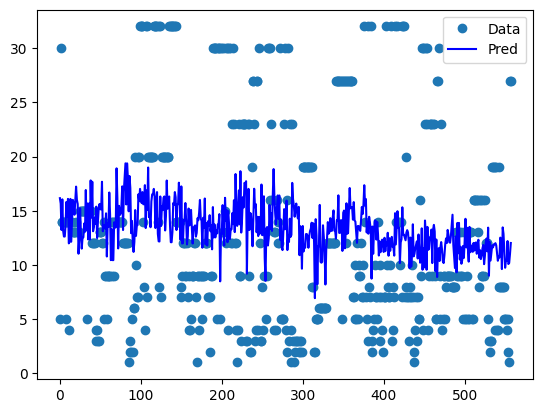

In [47]:
x = DENGUE_METEOR_FOUR.iloc[:,-5:-1]
y = DENGUE_METEOR_FOUR['mos']

lm_mos = LinearRegression()
lm_mos.fit(x,y)
predicted_mos = lm_mos.predict(x)
predicted_mos = sm.add_constant(predicted_mos, prepend = False)

glm_pois = sm.GLM(DENGUE_METEOR_FOUR['MONTH_COUNT'], predicted_mos, family = sm.families.Poisson())
res = glm_pois.fit()
y_pred = res.predict(predicted_mos)
print('Mean absolute error of prediction is:', skm.mean_absolute_error(DENGUE_METEOR_FOUR['MONTH_COUNT'], y_pred))
print('Mean absolute percentage error is:', skm.mean_absolute_percentage_error(DENGUE_METEOR_FOUR['MONTH_COUNT'], y_pred))
print(res.summary())

fig, ax = plt.subplots()
ax.plot(DENGUE_METEOR_FOUR['MONTH_COUNT'], "o", label="Data")
ax.plot(y_pred, "b-", label="Pred")
ax.legend(loc="best")

## Dengue cases per month predicted at each case based on meteorlogical conditions

Mean absolute error of prediction is: 6.673026165988001
Mean absolute percentage error is: 0.9990509943001215
                 Generalized Linear Model Regression Results                  
Dep. Variable:            MONTH_COUNT   No. Observations:                  572
Model:                            GLM   Df Residuals:                      567
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2643.6
Date:                Tue, 13 Dec 2022   Deviance:                       2874.3
Time:                        20:22:54   Pearson chi2:                 2.86e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4380
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------

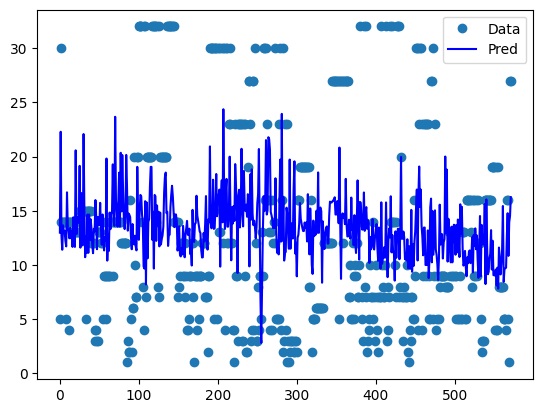

In [48]:
x = DENGUE_METEOR.iloc[:,-5:-1]
x = sm.add_constant(x, prepend = False)

glm_pois = sm.GLM(DENGUE_METEOR['MONTH_COUNT'], x, family = sm.families.Poisson())
res = glm_pois.fit()
y_pred = res.predict(x)
print('Mean absolute error of prediction is:', skm.mean_absolute_error(DENGUE_METEOR['MONTH_COUNT'], y_pred))
print('Mean absolute percentage error is:', skm.mean_absolute_percentage_error(DENGUE_METEOR['MONTH_COUNT'], y_pred))
print(res.summary())

fig, ax = plt.subplots()
ax.plot(DENGUE_METEOR['MONTH_COUNT'], "o", label="Data")
ax.plot(y_pred, "b-", label="Pred")
ax.legend(loc="best")

Mean absolute error of prediction is: 6.577754171165761
Mean absolute percentage error is: 0.9681247358108724
                 Generalized Linear Model Regression Results                  
Dep. Variable:            MONTH_COUNT   No. Observations:                  567
Model:                            GLM   Df Residuals:                      562
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2592.2
Date:                Tue, 13 Dec 2022   Deviance:                       2798.6
Time:                        20:22:54   Pearson chi2:                 2.81e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.5090
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------

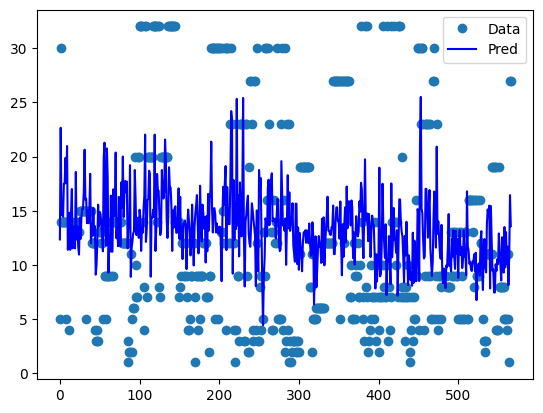

In [49]:
x = DENGUE_METEOR_TWO.iloc[:,-5:-1]
x = sm.add_constant(x, prepend = False)

glm_pois = sm.GLM(DENGUE_METEOR_TWO['MONTH_COUNT'], x, family = sm.families.Poisson())
res = glm_pois.fit()
y_pred = res.predict(x)
print('Mean absolute error of prediction is:', skm.mean_absolute_error(DENGUE_METEOR_TWO['MONTH_COUNT'], y_pred))
print('Mean absolute percentage error is:', skm.mean_absolute_percentage_error(DENGUE_METEOR_TWO['MONTH_COUNT'], y_pred))
print(res.summary())

fig, ax = plt.subplots()
ax.plot(DENGUE_METEOR_TWO['MONTH_COUNT'], "o", label="Data")
ax.plot(y_pred, "b-", label="Pred")
ax.legend(loc="best")

Mean absolute error of prediction is: 6.8631194529262745
Mean absolute percentage error is: 1.0173703575020063
                 Generalized Linear Model Regression Results                  
Dep. Variable:            MONTH_COUNT   No. Observations:                  558
Model:                            GLM   Df Residuals:                      553
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2662.3
Date:                Tue, 13 Dec 2022   Deviance:                       2980.3
Time:                        20:22:54   Pearson chi2:                 3.05e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3576
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------

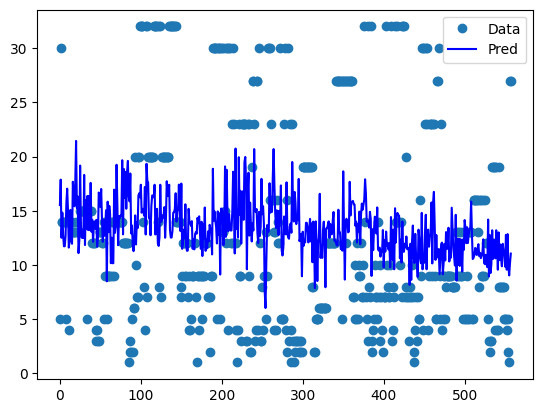

In [50]:
x = DENGUE_METEOR_FOUR.iloc[:,-5:-1]
x = sm.add_constant(x, prepend = False)

glm_pois = sm.GLM(DENGUE_METEOR_FOUR['MONTH_COUNT'], x, family = sm.families.Poisson())
res = glm_pois.fit()
y_pred = res.predict(x)
print('Mean absolute error of prediction is:', skm.mean_absolute_error(DENGUE_METEOR_FOUR['MONTH_COUNT'], y_pred))
print('Mean absolute percentage error is:', skm.mean_absolute_percentage_error(DENGUE_METEOR_FOUR['MONTH_COUNT'], y_pred))
print(res.summary())

fig, ax = plt.subplots()
ax.plot(DENGUE_METEOR_FOUR['MONTH_COUNT'], "o", label="Data")
ax.plot(y_pred, "b-", label="Pred")
ax.legend(loc="best")

## GLM MODEL

Mean absolute error of prediction is: 4.266939546415368
Root Mean squared error is: 5.123607169573334
                 Generalized Linear Model Regression Results                  
Dep. Variable:           DENGUE_COUNT   No. Observations:                   75
Model:                            GLM   Df Residuals:                       70
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -280.10
Date:                Tue, 13 Dec 2022   Deviance:                       325.30
Time:                        20:22:54   Pearson chi2:                     293.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3211
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

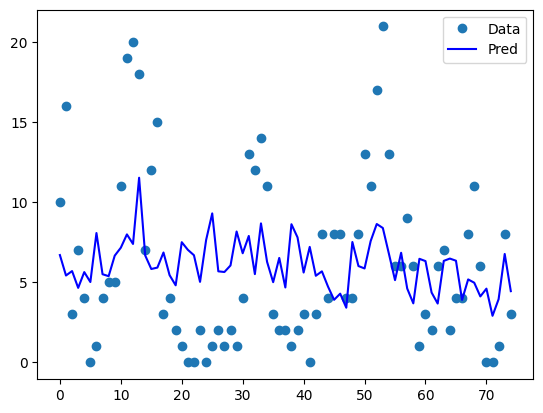

In [51]:
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.graphics.api import abline_plot
import sklearn.metrics as skm
import scipy

x = dengue_count_df.iloc[:,-4:]
x = sm.add_constant(x, prepend = False)

glm_pois = sm.GLM(dengue_count_df['DENGUE_COUNT'], x, family = sm.families.Poisson())
res = glm_pois.fit()
y_pred = res.predict(x)
print('Mean absolute error of prediction is:', skm.mean_absolute_error(dengue_count_df['DENGUE_COUNT'], y_pred))
print('Root Mean squared error is:', skm.mean_squared_error(dengue_count_df['DENGUE_COUNT'], y_pred)**0.5)
print(res.summary())

fig, ax = plt.subplots()
ax.plot(dengue_count_df['DENGUE_COUNT'], "o", label="Data")
ax.plot(y_pred, "b-", label="Pred")
ax.legend(loc="best")
dy_test = y_pred[64:]

## TIME-SERIES ANALYSIS



## Data Extraction and Analysis

In [52]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
%matplotlib inline      

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from pandas.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings('ignore')

In [53]:
dengue_count_df = pd.read_sql("SELECT * FROM DENGUE_TWO_AVER;",con=conn)
dengue_count_df["MONTH"] = dengue_count_df['YEAR(Symptoms)'].astype(str) +" "+ dengue_count_df['MONTHNAME(Symptoms)']
del dengue_count_df['YEAR(Symptoms)']
del dengue_count_df['MONTHNAME(Symptoms)']
print(dengue_count_df)

    DENGUE_COUNT   AVER_MAX   AVER_MIN  AVER_AVER  AVER_HUMIDITY  \
0             11  27.482955  19.545455  23.784091      78.346591   
1             19  26.697368  20.884868  23.342105      85.424342   
2              4  27.812500  23.250000  25.375000      78.187500   
3              8  26.703125  20.710938  23.507812      82.046875   
4              5  27.037500  20.387500  23.687500      80.000000   
..           ...        ...        ...        ...            ...   
70             1  27.375000  18.437500  23.062500      83.312500   
71             1  26.437500  22.437500  23.875000      81.750000   
72             2  26.937500  20.906250  23.562500      84.625000   
73             9  28.291667  20.701389  24.131944      85.187500   
74             4  27.265625  21.062500  23.703125      87.078125   

             MONTH  
0     2015 January  
1    2015 February  
2       2015 March  
3       2015 April  
4         2015 May  
..             ...  
70       2021 July  
71  2021 Septem

In [54]:
#Converting the month column from string to date time
dengue_count_df['MONTH']=pd.to_datetime(dengue_count_df['MONTH'])
dengue_count_df.head(5)

,DENGUE_COUNT,AVER_MAX,AVER_MIN,AVER_AVER,AVER_HUMIDITY,MONTH
0,11,27.482955,19.545455,23.784091,78.346591,2015-01-01
1,19,26.697368,20.884868,23.342105,85.424342,2015-02-01
2,4,27.812500,23.250000,25.375000,78.187500,2015-03-01
3,8,26.703125,20.710938,23.507812,82.046875,2015-04-01
4,5,27.037500,20.387500,23.687500,80.000000,2015-05-01


In [55]:
groupby_day = dengue_count_df.groupby(pd.PeriodIndex(data=dengue_count_df.MONTH, freq='M'))
results = groupby_day.sum()
results

,DENGUE_COUNT,AVER_MAX,AVER_MIN,AVER_AVER,AVER_HUMIDITY
MONTH,,,,,
2015-01,11,27.482955,19.545455,23.784091,78.346591
2015-02,19,26.697368,20.884868,23.342105,85.424342
2015-03,4,27.812500,23.250000,25.375000,78.187500
2015-04,8,26.703125,20.710938,23.507812,82.046875
2015-05,5,27.037500,20.387500,23.687500,80.000000
...,...,...,...,...,...
2021-07,1,27.375000,18.437500,23.062500,83.312500
2021-09,1,26.437500,22.437500,23.875000,81.750000
2021-10,2,26.937500,20.906250,23.562500,84.625000


In [56]:
idx = pd.period_range(min(dengue_count_df.MONTH), max(dengue_count_df.MONTH), freq= 'M')
dengue_count_df = results.reindex(idx, fill_value=0)

dengue_count_df

,DENGUE_COUNT,AVER_MAX,AVER_MIN,AVER_AVER,AVER_HUMIDITY
2015-01,11,27.482955,19.545455,23.784091,78.346591
2015-02,19,26.697368,20.884868,23.342105,85.424342
2015-03,4,27.812500,23.250000,25.375000,78.187500
2015-04,8,26.703125,20.710938,23.507812,82.046875
2015-05,5,27.037500,20.387500,23.687500,80.000000
...,...,...,...,...,...
2021-08,0,0.000000,0.000000,0.000000,0.000000
2021-09,1,26.437500,22.437500,23.875000,81.750000
2021-10,2,26.937500,20.906250,23.562500,84.625000
2021-11,9,28.291667,20.701389,24.131944,85.187500


In [57]:
dengue_count_df.dtypes
dengue_count_df.describe()

,DENGUE_COUNT,AVER_MAX,AVER_MIN,AVER_AVER,AVER_HUMIDITY
count,84.000000,84.000000,84.000000,84.000000,84.000000
mean,6.750000,24.746376,18.659963,21.517539,73.648451
std,6.741125,8.710856,6.578207,7.555472,26.190116
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,26.701686,19.802083,23.366776,78.739583
50%,5.000000,27.289062,20.730469,23.885417,82.569010
75%,9.000000,28.143229,21.322917,24.325446,85.438792
max,32.000000,33.291667,24.208333,28.354167,91.291667


In [58]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(cases):
    result = adfuller(cases)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print('Weak evidence against null hypothesis, time series has unit root, indicating it is non-stationary')

In [59]:
adfuller_test(dengue_count_df['DENGUE_COUNT'])

ADF Test Statistic : -3.8350132652263382
p-value : 0.002568726590228407
#Lags Used : 0
Number of Observations Used : 83
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:>

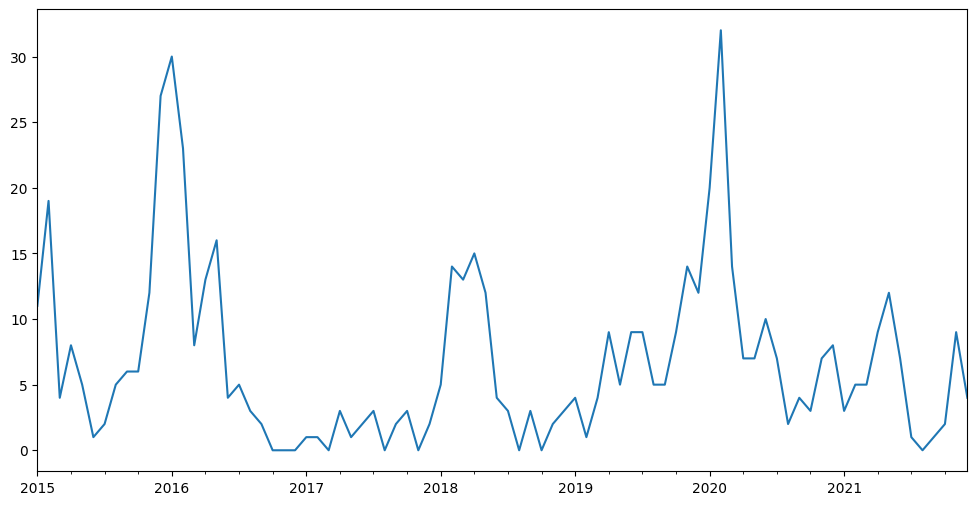

In [60]:
## Visualize the time series data
dengue_count_df.DENGUE_COUNT.plot(figsize=(12,6))

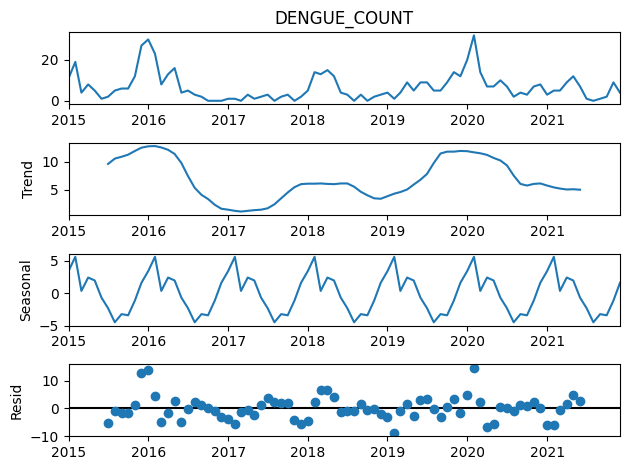

In [61]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
dengue_count_df.interpolate(inplace = True)
dengue_count_df.index=dengue_count_df.index.to_timestamp()
#dengue_count_df
results=seasonal_decompose(dengue_count_df.DENGUE_COUNT,model='additive').plot();

In [62]:
DCtrain=dengue_count_df.DENGUE_COUNT[:64]
DCtest=dengue_count_df.DENGUE_COUNT[64:]
#DC for dengue count

Ttrain = dengue_count_df.AVER_MAX[:64]
Ttest = dengue_count_df.AVER_MAX[64:]
#T for temperatue

Htrain = dengue_count_df.AVER_HUMIDITY[:64]
Htest = dengue_count_df.AVER_HUMIDITY[64:]
#H for humidity

#### Holt Winter's

In [63]:
dengue_count_df = pd.read_sql("SELECT * FROM DENGUE_TWO_AVER;",con=conn)

In [64]:
dengue_count_df["MONTH"] = dengue_count_df['YEAR(Symptoms)'].astype(str) +" "+ dengue_count_df['MONTHNAME(Symptoms)']
del dengue_count_df['YEAR(Symptoms)']
del dengue_count_df['MONTHNAME(Symptoms)']
print(dengue_count_df)

    DENGUE_COUNT   AVER_MAX   AVER_MIN  AVER_AVER  AVER_HUMIDITY  \
0             11  27.482955  19.545455  23.784091      78.346591   
1             19  26.697368  20.884868  23.342105      85.424342   
2              4  27.812500  23.250000  25.375000      78.187500   
3              8  26.703125  20.710938  23.507812      82.046875   
4              5  27.037500  20.387500  23.687500      80.000000   
..           ...        ...        ...        ...            ...   
70             1  27.375000  18.437500  23.062500      83.312500   
71             1  26.437500  22.437500  23.875000      81.750000   
72             2  26.937500  20.906250  23.562500      84.625000   
73             9  28.291667  20.701389  24.131944      85.187500   
74             4  27.265625  21.062500  23.703125      87.078125   

             MONTH  
0     2015 January  
1    2015 February  
2       2015 March  
3       2015 April  
4         2015 May  
..             ...  
70       2021 July  
71  2021 Septem

In [65]:
#Converting the month column from string to date time
dengue_count_df['MONTH']=pd.to_datetime(dengue_count_df['MONTH'])

In [66]:
dengue_count_df.head(5)

,DENGUE_COUNT,AVER_MAX,AVER_MIN,AVER_AVER,AVER_HUMIDITY,MONTH
0,11,27.482955,19.545455,23.784091,78.346591,2015-01-01
1,19,26.697368,20.884868,23.342105,85.424342,2015-02-01
2,4,27.812500,23.250000,25.375000,78.187500,2015-03-01
3,8,26.703125,20.710938,23.507812,82.046875,2015-04-01
4,5,27.037500,20.387500,23.687500,80.000000,2015-05-01


In [67]:
groupby_day = dengue_count_df.groupby(pd.PeriodIndex(data=dengue_count_df.MONTH, freq='M'))
results = groupby_day.sum()
results

,DENGUE_COUNT,AVER_MAX,AVER_MIN,AVER_AVER,AVER_HUMIDITY
MONTH,,,,,
2015-01,11,27.482955,19.545455,23.784091,78.346591
2015-02,19,26.697368,20.884868,23.342105,85.424342
2015-03,4,27.812500,23.250000,25.375000,78.187500
2015-04,8,26.703125,20.710938,23.507812,82.046875
2015-05,5,27.037500,20.387500,23.687500,80.000000
...,...,...,...,...,...
2021-07,1,27.375000,18.437500,23.062500,83.312500
2021-09,1,26.437500,22.437500,23.875000,81.750000
2021-10,2,26.937500,20.906250,23.562500,84.625000


In [68]:
idx = pd.period_range(min(dengue_count_df.MONTH), max(dengue_count_df.MONTH), freq= 'M')
dengue_count_df = results.reindex(idx, fill_value=0)

dengue_count_df

,DENGUE_COUNT,AVER_MAX,AVER_MIN,AVER_AVER,AVER_HUMIDITY
2015-01,11,27.482955,19.545455,23.784091,78.346591
2015-02,19,26.697368,20.884868,23.342105,85.424342
2015-03,4,27.812500,23.250000,25.375000,78.187500
2015-04,8,26.703125,20.710938,23.507812,82.046875
2015-05,5,27.037500,20.387500,23.687500,80.000000
...,...,...,...,...,...
2021-08,0,0.000000,0.000000,0.000000,0.000000
2021-09,1,26.437500,22.437500,23.875000,81.750000
2021-10,2,26.937500,20.906250,23.562500,84.625000
2021-11,9,28.291667,20.701389,24.131944,85.187500


In [69]:
#Creating month as the index of the data set
#dengue_count_df.set_index('MONTH',inplace=True)
print(len(dengue_count_df))
dengue_count_df.head(5)

84


,DENGUE_COUNT,AVER_MAX,AVER_MIN,AVER_AVER,AVER_HUMIDITY
2015-01,11,27.482955,19.545455,23.784091,78.346591
2015-02,19,26.697368,20.884868,23.342105,85.424342
2015-03,4,27.812500,23.250000,25.375000,78.187500
2015-04,8,26.703125,20.710938,23.507812,82.046875
2015-05,5,27.037500,20.387500,23.687500,80.000000


In [70]:
dengue_count_df.dtypes
dengue_count_df.describe()

,DENGUE_COUNT,AVER_MAX,AVER_MIN,AVER_AVER,AVER_HUMIDITY
count,84.000000,84.000000,84.000000,84.000000,84.000000
mean,6.750000,24.746376,18.659963,21.517539,73.648451
std,6.741125,8.710856,6.578207,7.555472,26.190116
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,26.701686,19.802083,23.366776,78.739583
50%,5.000000,27.289062,20.730469,23.885417,82.569010
75%,9.000000,28.143229,21.322917,24.325446,85.438792
max,32.000000,33.291667,24.208333,28.354167,91.291667


#### Visualize the data in a plot and also use seasonal decompose library to separate the trend and seasonality in the data if any.

<AxesSubplot:>

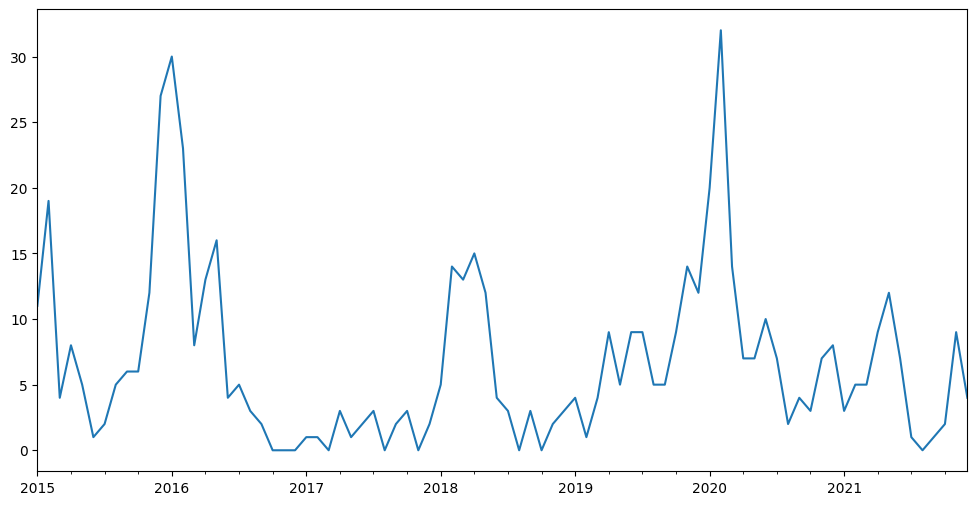

In [71]:
## Visualize the time series data
dengue_count_df.DENGUE_COUNT.plot(figsize=(12,6))

In [72]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

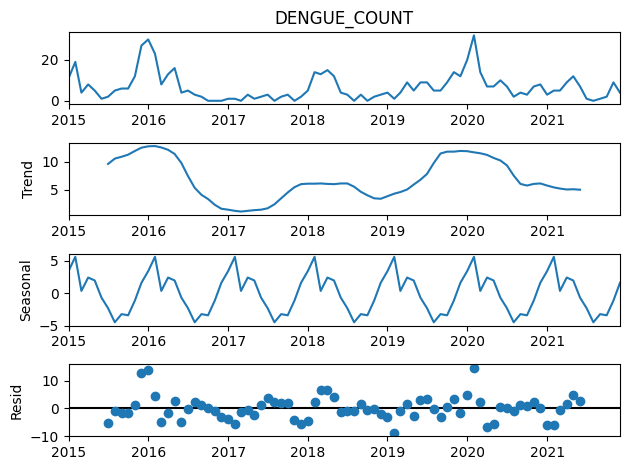

In [73]:
dengue_count_df.interpolate(inplace = True)
dengue_count_df.index=dengue_count_df.index.to_timestamp()
#Periods don't work with seasonal_decompose, timestamps do
#dengue_count_df
results=seasonal_decompose(dengue_count_df.DENGUE_COUNT,model='additive').plot();

#### Train Test split

In [74]:
len(dengue_count_df)

84

In [75]:
train=dengue_count_df.DENGUE_COUNT[:64]
test=dengue_count_df.DENGUE_COUNT[64:]

In [76]:
len(test),len(train)

(20, 64)

#### Holt Winters Model

In [77]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [78]:
holt_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=20)
hwmodel = holt_model.fit()

In [79]:
test_pred=hwmodel.forecast(20)

In [80]:
test_pred


2020-05-01     8.664273
2020-06-01     6.330941
2020-07-01     6.997609
2020-08-01     9.330940
2020-09-01     9.330936
2020-10-01     8.664268
2020-11-01    11.997599
2020-12-01    17.664265
2021-01-01    17.997595
2021-02-01    17.330925
2021-03-01    11.330919
2021-04-01    12.330913
2021-05-01    14.330908
2021-06-01    14.664234
2021-07-01    16.330894
2021-08-01    15.664224
2021-09-01    16.766631
2021-10-01    19.266631
2021-11-01    10.766631
2021-12-01     9.266631
Freq: MS, dtype: float64

<AxesSubplot:>

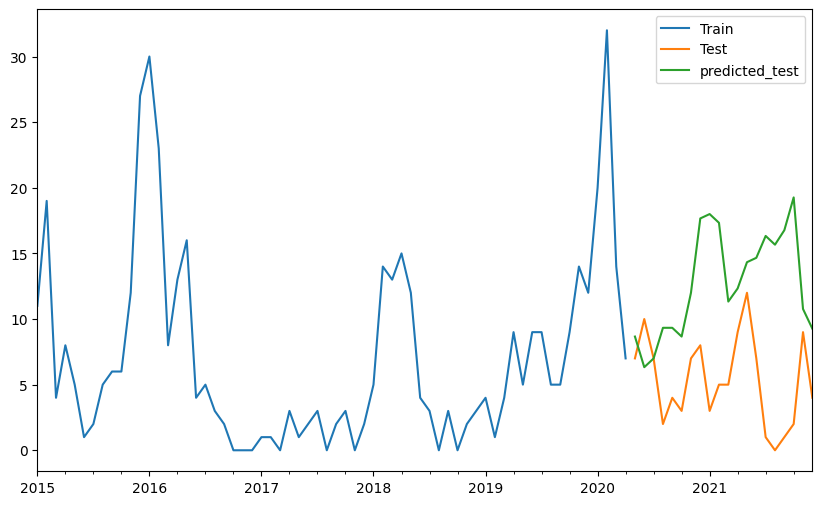

In [81]:
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend=True, label='Test')
test_pred.plot(legend=True, label='predicted_test')

In [82]:
import math
MSE = np.square(np.subtract(test,test_pred)).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

9.484634444510322


In [83]:
print('Mean absolute percentage error is:', mean_absolute_percentage_error(test,test_pred))

Mean absolute percentage error is: 3527269753832127.0


In [84]:
stdev = np.sqrt(dengue_count_df.var())
stdev

DENGUE_COUNT      6.741125
AVER_MAX          8.710856
AVER_MIN          6.578207
AVER_AVER         7.555472
AVER_HUMIDITY    26.190116
dtype: float64

In [85]:
dengue_count_df.mean(), stdev, RMSE

(DENGUE_COUNT      6.750000
 AVER_MAX         24.746376
 AVER_MIN         18.659963
 AVER_AVER        21.517539
 AVER_HUMIDITY    73.648451
 dtype: float64,
 DENGUE_COUNT      6.741125
 AVER_MAX          8.710856
 AVER_MIN          6.578207
 AVER_AVER         7.555472
 AVER_HUMIDITY    26.190116
 dtype: float64,
 9.484634444510322)

#### Final Model

In [86]:
final_model = ExponentialSmoothing(dengue_count_df.DENGUE_COUNT, trend='add', seasonal='add', seasonal_periods=20).fit()

In [87]:
pred = final_model.forecast(24)
pred

2022-01-01     4.449837
2022-02-01     3.449935
2022-03-01     3.199757
2022-04-01     3.699953
2022-05-01     4.200072
2022-06-01     3.450073
2022-07-01     6.950119
2022-08-01    11.449958
2022-09-01    10.449949
2022-10-01    10.450008
2022-11-01     5.949906
2022-12-01     7.699871
2023-01-01     9.949916
2023-02-01     8.949873
2023-03-01     8.700072
2023-04-01     7.949825
2023-05-01     9.060917
2023-06-01    11.260982
2023-07-01     5.860861
2023-08-01     3.660718
2023-09-01     3.950745
2023-10-01     2.950842
2023-11-01     2.700665
2023-12-01     3.200860
Freq: MS, dtype: float64

<AxesSubplot:>

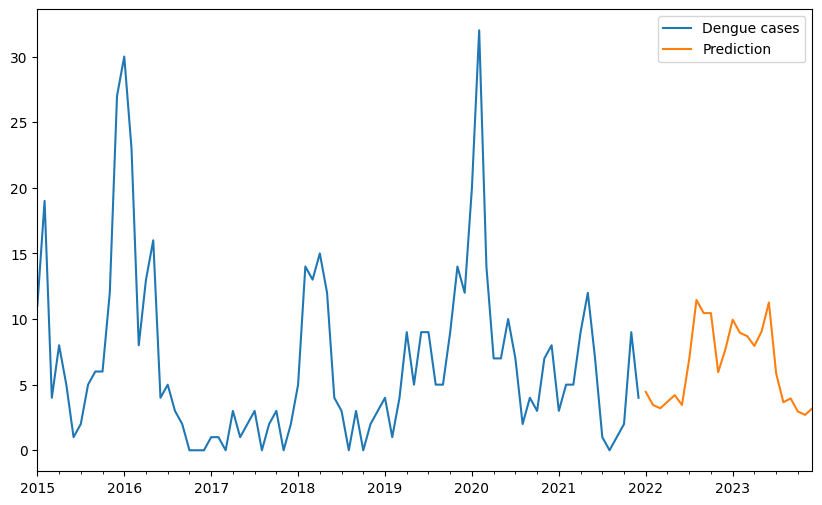

In [88]:
#  Plotting the data and the new prediction for the next 24 months.
dengue_count_df.DENGUE_COUNT.plot(legend=True, label='Dengue cases', figsize=(10,6))
pred.plot(legend=True, label='Prediction')

In [89]:
stdev = np.sqrt(dengue_count_df.var())
stdev

DENGUE_COUNT      6.741125
AVER_MAX          8.710856
AVER_MIN          6.578207
AVER_AVER         7.555472
AVER_HUMIDITY    26.190116
dtype: float64

## Autoregressive

#### Visualize the Time Series Data
#### Make the time series data stationary
#### Plot the Correlation and AutoCorrelation Charts
#### Construct the AR Model based on the data
#### Use the model to make predictions

In [90]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
%matplotlib inline      

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from pandas.plotting import autocorrelation_plot
import scipy

import warnings
warnings.filterwarnings('ignore')

In [91]:
import MySQLdb

In [92]:
groupvars = {}
with open("project_db") as myfile:
    for line in myfile:
        name, var = line.partition(":")[::2]
        groupvars[name.strip()] = var.strip()

conn = MySQLdb.connect(host="localhost", user=groupvars['DB username'], 
                       passwd=groupvars['DB password'], db=groupvars['DB databasename'])
cursor = conn.cursor()

In [93]:
list((1,2,3))

[1, 2, 3]

In [94]:
dengue_count_df = pd.read_sql("SELECT * FROM DENGUE_TWO_AVER;",con=conn)
dengue_count_df_full = pd.read_sql('SELECT * FROM DENGUE_TWO_AVER;', con = conn)

In [95]:
dengue_count_df["MONTH"] = dengue_count_df['YEAR(Symptoms)'].astype(str) +" "+ dengue_count_df['MONTHNAME(Symptoms)']
del dengue_count_df['YEAR(Symptoms)']
del dengue_count_df['MONTHNAME(Symptoms)']
del dengue_count_df['AVER_MAX']
del dengue_count_df['AVER_MIN']
del dengue_count_df['AVER_AVER']
del dengue_count_df['AVER_HUMIDITY']
print(dengue_count_df)

dengue_count_df_full["MONTH"] = dengue_count_df_full['YEAR(Symptoms)'].astype(str) +" "+ \
    dengue_count_df_full['MONTHNAME(Symptoms)']
del dengue_count_df_full['YEAR(Symptoms)']
del dengue_count_df_full['MONTHNAME(Symptoms)']
print(dengue_count_df_full)

    DENGUE_COUNT           MONTH
0             11    2015 January
1             19   2015 February
2              4      2015 March
3              8      2015 April
4              5        2015 May
..           ...             ...
70             1       2021 July
71             1  2021 September
72             2    2021 October
73             9   2021 November
74             4   2021 December

[75 rows x 2 columns]
    DENGUE_COUNT   AVER_MAX   AVER_MIN  AVER_AVER  AVER_HUMIDITY  \
0             11  27.482955  19.545455  23.784091      78.346591   
1             19  26.697368  20.884868  23.342105      85.424342   
2              4  27.812500  23.250000  25.375000      78.187500   
3              8  26.703125  20.710938  23.507812      82.046875   
4              5  27.037500  20.387500  23.687500      80.000000   
..           ...        ...        ...        ...            ...   
70             1  27.375000  18.437500  23.062500      83.312500   
71             1  26.437500  22.43750

In [96]:
#Converting the month column from string to date time
dengue_count_df['MONTH']=pd.to_datetime(dengue_count_df['MONTH'])
dengue_count_df_full['MONTH'] = pd.to_datetime(dengue_count_df_full['MONTH'])

In [97]:
dengue_count_df.head(5)

,DENGUE_COUNT,MONTH
0,11,2015-01-01
1,19,2015-02-01
2,4,2015-03-01
3,8,2015-04-01
4,5,2015-05-01


In [98]:
dengue_count_df_full.head(5)

,DENGUE_COUNT,AVER_MAX,AVER_MIN,AVER_AVER,AVER_HUMIDITY,MONTH
0,11,27.482955,19.545455,23.784091,78.346591,2015-01-01
1,19,26.697368,20.884868,23.342105,85.424342,2015-02-01
2,4,27.812500,23.250000,25.375000,78.187500,2015-03-01
3,8,26.703125,20.710938,23.507812,82.046875,2015-04-01
4,5,27.037500,20.387500,23.687500,80.000000,2015-05-01


In [99]:
#Creating month as the index of the data set
dengue_count_df.set_index('MONTH',inplace=True)
dengue_count_df_full.set_index('MONTH', inplace=True)
print(dengue_count_df.head(5))
print(dengue_count_df_full.head(5))

            DENGUE_COUNT
MONTH                   
2015-01-01            11
2015-02-01            19
2015-03-01             4
2015-04-01             8
2015-05-01             5
            DENGUE_COUNT   AVER_MAX   AVER_MIN  AVER_AVER  AVER_HUMIDITY
MONTH                                                                   
2015-01-01            11  27.482955  19.545455  23.784091      78.346591
2015-02-01            19  26.697368  20.884868  23.342105      85.424342
2015-03-01             4  27.812500  23.250000  25.375000      78.187500
2015-04-01             8  26.703125  20.710938  23.507812      82.046875
2015-05-01             5  27.037500  20.387500  23.687500      80.000000


In [100]:
dengue_count_df=dengue_count_df.resample('MS').sum()
dengue_count_df_full = dengue_count_df_full.resample('MS').sum()
print(len(dengue_count_df))
print(len(dengue_count_df_full))

84
84


<AxesSubplot:xlabel='MONTH'>

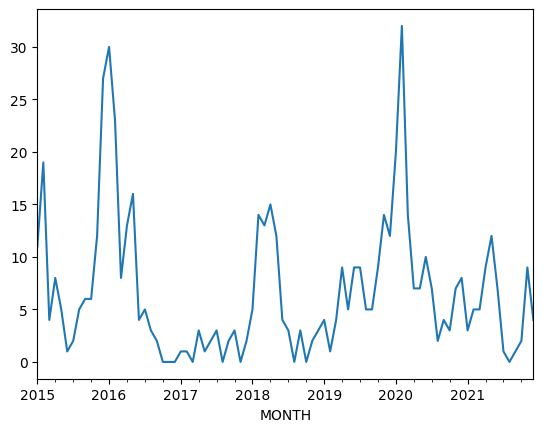

In [101]:
## Visualize the time series data
dengue_count_df['DENGUE_COUNT'].plot()

## Trained GLM Model to correlate with Time Series

In [102]:
Ttest=dengue_count_df_full[:64]
Ttrain=dengue_count_df_full[64:]
len(Ttest),len(Ttrain)

(64, 20)

Mean absolute error of prediction is: 1.2353706457536486
Root Mean squared error is: 1.6920589705798779
                 Generalized Linear Model Regression Results                  
Dep. Variable:               AVER_MAX   No. Observations:                   84
Model:                            GLM   Df Residuals:                       79
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -200.36
Date:                Tue, 13 Dec 2022   Deviance:                       13.356
Time:                        20:22:56   Pearson chi2:                     11.0
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9959
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------

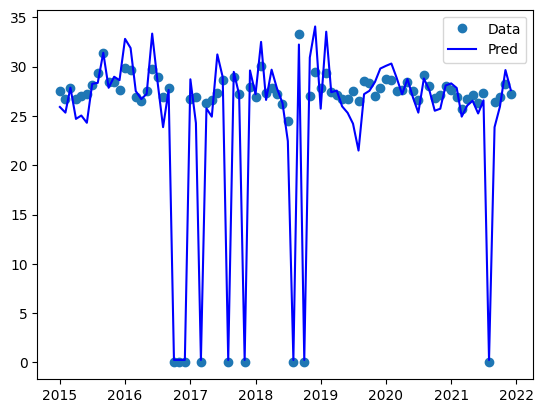

In [103]:
#Average Temp
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.graphics.api import abline_plot
import sklearn.metrics as skm

x = dengue_count_df_full.iloc[:,-4:]
x = sm.add_constant(x, prepend = False)

glm_pois = sm.GLM(dengue_count_df_full['AVER_MAX'], x, family = sm.families.Poisson())
res = glm_pois.fit()
y_pred = res.predict(x)
print('Mean absolute error of prediction is:', skm.mean_absolute_error(dengue_count_df_full['AVER_MAX'], y_pred))
print('Root Mean squared error is:', skm.mean_squared_error(dengue_count_df_full['AVER_MAX'], y_pred)**0.5)
print(res.summary())

fig, ax = plt.subplots()
ax.plot(dengue_count_df_full['AVER_MAX'], "o", label="Data")
ax.plot(y_pred, "b-", label="Pred")
ax.legend(loc="best")
ty_pred=y_pred[64:]

Mean absolute error of prediction is: 3.6889780730174744
Root Mean squared error is: 5.024388081854263
                 Generalized Linear Model Regression Results                  
Dep. Variable:          AVER_HUMIDITY   No. Observations:                   84
Model:                            GLM   Df Residuals:                       79
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -254.10
Date:                Tue, 13 Dec 2022   Deviance:                       39.442
Time:                        20:22:57   Pearson chi2:                     32.6
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

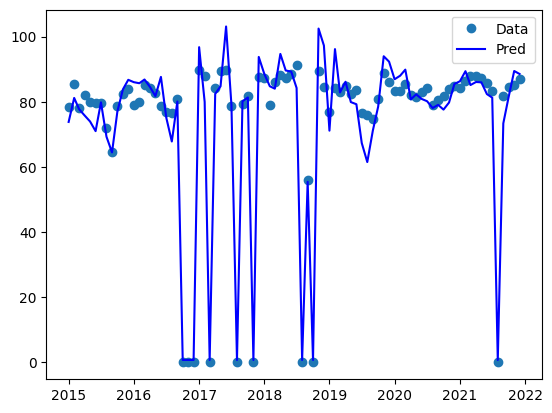

In [104]:
x = dengue_count_df_full.iloc[:,-4:]
x = sm.add_constant(x, prepend = False)

glm_pois = sm.GLM(dengue_count_df_full['AVER_HUMIDITY'], x, family = sm.families.Poisson())
res = glm_pois.fit()
y_pred = res.predict(x)

print('Mean absolute error of prediction is:', skm.mean_absolute_error(dengue_count_df_full['AVER_HUMIDITY'], y_pred))
print('Root Mean squared error is:', skm.mean_squared_error(dengue_count_df_full['AVER_HUMIDITY'], y_pred)**0.5)
print(res.summary())

fig, ax = plt.subplots()
ax.plot(dengue_count_df_full['AVER_HUMIDITY'], "o", label="Data")
ax.plot(y_pred, "b-", label="Pred")
ax.legend(loc="best")
hy_pred=y_pred[64:]

##### Testing for stationarity

In [105]:
test_result=adfuller(dengue_count_df)

In [106]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(cases):
    result=adfuller(cases)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [107]:
adfuller_test(dengue_count_df)

ADF Test Statistic : -3.8350132652263382
p-value : 0.002568726590228407
#Lags Used : 0
Number of Observations Used : 83
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


##### Test Train Split

In [108]:
len(dengue_count_df)

84

In [109]:
train=dengue_count_df[:64]
test=dengue_count_df[64:]

### AutoRegressive Model

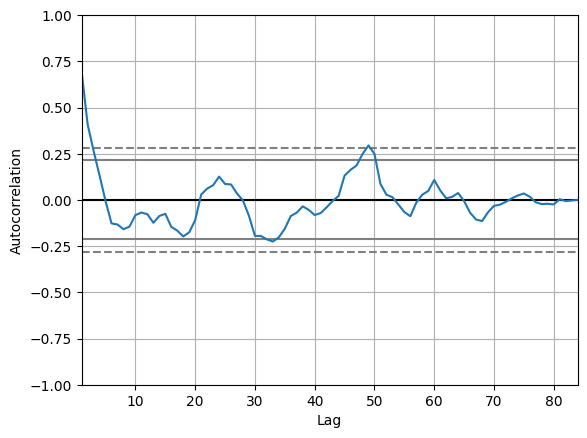

In [110]:
#AutoCorelation plot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(dengue_count_df)
plt.show()

In [111]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

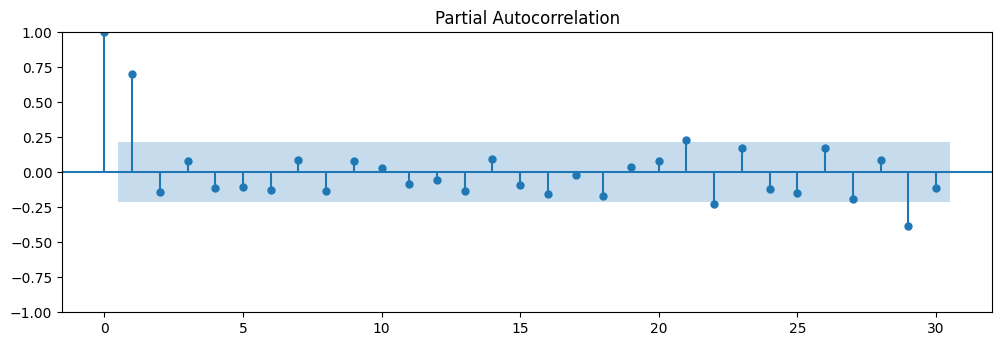

In [112]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dengue_count_df,lags=30,ax=ax2)

### Building AR Midel

In [113]:
from statsmodels.tsa.ar_model import AutoReg 

In [114]:
model=AutoReg(train,lags=3).fit()

In [115]:
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:           DENGUE_COUNT   No. Observations:                   64
Model:                     AutoReg(3)   Log Likelihood                -183.562
Method:               Conditional MLE   S.D. of innovations              4.905
Date:                Tue, 13 Dec 2022   AIC                            377.125
Time:                        20:22:57   BIC                            387.679
Sample:                    04-01-2015   HQIC                           381.261
                         - 04-01-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.0375      0.940      2.168      0.030       0.196       3.879
DENGUE_COUNT.L1     0.8582      0.122      7.034      0.000       0.619       1.097
DENGUE_COUNT.L2    -0.2104      

### Predict Test Dataset

In [116]:
pred=model.predict(start=len(train),end=(len(dengue_count_df)-1),dynamic=False)

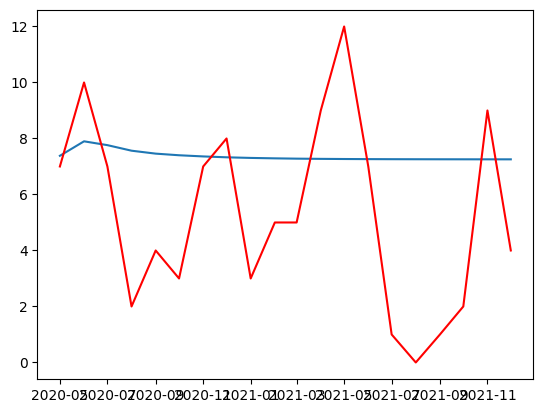

In [117]:
plt.plot(pred)
plt.plot(test,color='red')

### Model Evaluation 

In [118]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [119]:
import math
print('Root Mean squared error is:', skm.mean_squared_error(test,pred)**0.5)

Root Mean squared error is: 3.8388388260067603


In [120]:
print('Mean absolute error of prediction is:', skm.mean_absolute_error(test, pred))

Mean absolute error of prediction is: 3.1665212787088075


In [121]:
test.mean(),np.sqrt(test.var())

(DENGUE_COUNT    5.3
 dtype: float64,
 DENGUE_COUNT    3.357631
 dtype: float64)

In [122]:
pred_future=model.predict(start=len(train),end=(len(dengue_count_df)-1))
print("The future predictions for the next month")
print(pred_future)
print("The no. of predictions made: \t",len(pred_future))   

The future predictions for the next month
2020-05-01    7.381962
2020-06-01    7.898427
2020-07-01    7.761967
2020-08-01    7.563454
2020-09-01    7.458644
2020-10-01    7.400729
2020-11-01    7.358917
2020-12-01    7.327743
2021-01-01    7.305656
2021-02-01    7.290277
2021-03-01    7.279503
2021-04-01    7.271916
2021-05-01    7.266575
2021-06-01    7.262820
2021-07-01    7.260179
2021-08-01    7.258322
2021-09-01    7.257016
2021-10-01    7.256097
2021-11-01    7.255451
2021-12-01    7.254997
Freq: MS, dtype: float64
The no. of predictions made: 	 20


<AxesSubplot:xlabel='MONTH'>

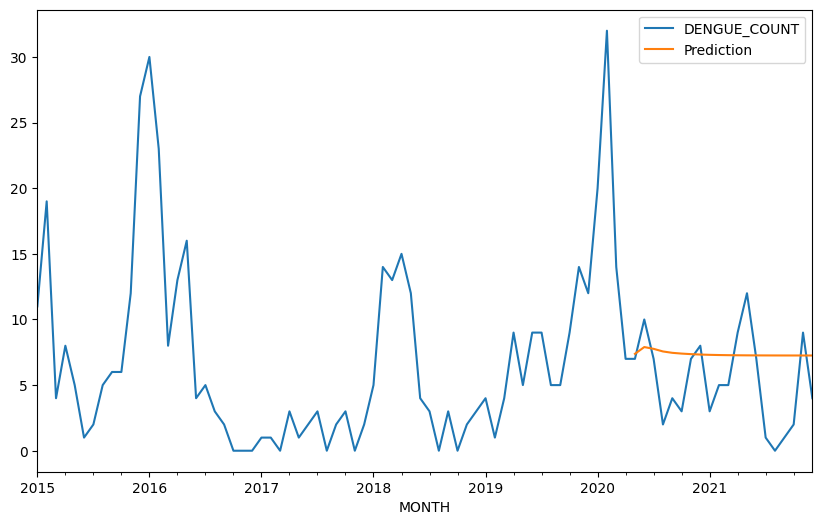

In [123]:
dengue_count_df.plot(legend=True, label='Dengue cases', figsize=(10,6))
pred.plot(legend=True, label='Prediction')

### Correlation 

In [124]:
pred_future

2020-05-01    7.381962
2020-06-01    7.898427
2020-07-01    7.761967
2020-08-01    7.563454
2020-09-01    7.458644
2020-10-01    7.400729
2020-11-01    7.358917
2020-12-01    7.327743
2021-01-01    7.305656
2021-02-01    7.290277
2021-03-01    7.279503
2021-04-01    7.271916
2021-05-01    7.266575
2021-06-01    7.262820
2021-07-01    7.260179
2021-08-01    7.258322
2021-09-01    7.257016
2021-10-01    7.256097
2021-11-01    7.255451
2021-12-01    7.254997
Freq: MS, dtype: float64

In [125]:
#df=actual dengue cases
df = test.reset_index()
# df=df.drop(columns=['MONTH'])
df.rename(columns = {'DENGUE_COUNT':'A_Dengue'}, inplace = True)
df

,MONTH,A_Dengue
0,2020-05-01,7
1,2020-06-01,10
2,2020-07-01,7
3,2020-08-01,2
4,2020-09-01,4
5,2020-10-01,3
6,2020-11-01,7
7,2020-12-01,8
8,2021-01-01,3
9,2021-02-01,5


In [126]:
#df1=predicted dengue cases
df1 = pred_future.reset_index()
# df1 =df1.drop(columns=['index'])
# df1
df1.rename(columns = {'index':'MONTH'}, inplace = True)
df1.rename(columns = {0:'P_Dengue'}, inplace = True)
df1

,MONTH,P_Dengue
0,2020-05-01,7.381962
1,2020-06-01,7.898427
2,2020-07-01,7.761967
3,2020-08-01,7.563454
4,2020-09-01,7.458644
5,2020-10-01,7.400729
6,2020-11-01,7.358917
7,2020-12-01,7.327743
8,2021-01-01,7.305656
9,2021-02-01,7.290277


In [127]:
#df3=predicted temperature
df3 = ty_pred.reset_index()
# df3 =df3.drop(columns=['MONTH'])
df3.rename(columns = {0:'P_Temp'}, inplace = True)
df3

,MONTH,P_Temp
0,2020-05-01,28.747183
1,2020-06-01,26.862787
2,2020-07-01,25.339134
3,2020-08-01,28.800164
4,2020-09-01,27.602726
5,2020-10-01,25.531501
6,2020-11-01,25.737112
7,2020-12-01,28.094887
8,2021-01-01,28.303510
9,2021-02-01,27.838706


In [128]:
#df2=predicted humidity
df2 = hy_pred.reset_index()
# df2 =df2.drop(columns=['MONTH'])
df2.rename(columns = {0:'P_Humidity'}, inplace = True)
df2

,MONTH,P_Humidity
0,2020-05-01,82.274471
1,2020-06-01,80.859788
2,2020-07-01,80.164776
3,2020-08-01,78.077973
4,2020-09-01,79.040332
5,2020-10-01,77.592562
6,2020-11-01,79.765974
7,2020-12-01,85.467107
8,2021-01-01,86.289981
9,2021-02-01,89.380470


In [129]:
cor_df = pd.merge(df,df2, how="outer", on=["MONTH"])

In [130]:
cor_df.rename(columns = {'0':'P_Humidity'}, inplace = True)
cor_df

,MONTH,A_Dengue,P_Humidity
0,2020-05-01,7,82.274471
1,2020-06-01,10,80.859788
2,2020-07-01,7,80.164776
3,2020-08-01,2,78.077973
4,2020-09-01,4,79.040332
5,2020-10-01,3,77.592562
6,2020-11-01,7,79.765974
7,2020-12-01,8,85.467107
8,2021-01-01,3,86.289981
9,2021-02-01,5,89.380470


In [131]:
cor_df = pd.merge(cor_df,df3, how="outer", on=["MONTH"])
#cor_df=cor_df.drop('P_Temp_y')
cor_df

,MONTH,A_Dengue,P_Humidity,P_Temp
0,2020-05-01,7,82.274471,28.747183
1,2020-06-01,10,80.859788,26.862787
2,2020-07-01,7,80.164776,25.339134
3,2020-08-01,2,78.077973,28.800164
4,2020-09-01,4,79.040332,27.602726
5,2020-10-01,3,77.592562,25.531501
6,2020-11-01,7,79.765974,25.737112
7,2020-12-01,8,85.467107,28.094887
8,2021-01-01,3,86.289981,28.303510
9,2021-02-01,5,89.380470,27.838706


In [132]:
cor_df = pd.merge(cor_df,df1, how="outer", on=["MONTH"])
#cor_df=cor_df.drop('P_Temp_y')
cor_df

,MONTH,A_Dengue,P_Humidity,P_Temp,P_Dengue
0,2020-05-01,7,82.274471,28.747183,7.381962
1,2020-06-01,10,80.859788,26.862787,7.898427
2,2020-07-01,7,80.164776,25.339134,7.761967
3,2020-08-01,2,78.077973,28.800164,7.563454
4,2020-09-01,4,79.040332,27.602726,7.458644
5,2020-10-01,3,77.592562,25.531501,7.400729
6,2020-11-01,7,79.765974,25.737112,7.358917
7,2020-12-01,8,85.467107,28.094887,7.327743
8,2021-01-01,3,86.289981,28.303510,7.305656
9,2021-02-01,5,89.380470,27.838706,7.290277


In [133]:
corr_matrix = cor_df.corr()
corr_matrix

,A_Dengue,P_Humidity,P_Temp,P_Dengue
A_Dengue,1.000000,0.454055,0.394986,0.247550
P_Humidity,0.454055,1.000000,0.972425,0.060812
P_Temp,0.394986,0.972425,1.000000,0.147455
P_Dengue,0.247550,0.060812,0.147455,1.000000


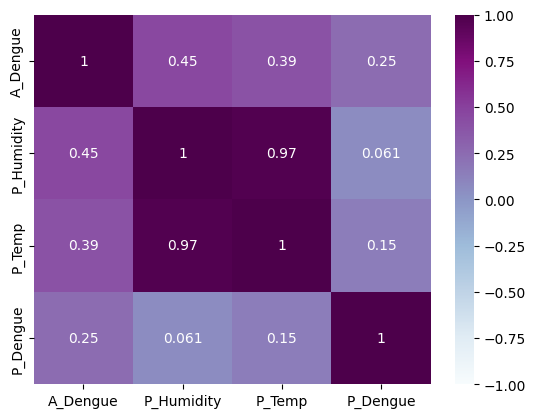

In [134]:
sns.heatmap(corr_matrix, vmin = -1, vmax =1, annot=True,cmap="BuPu")
plt.show()

# Random Forest Regressor

In [135]:
from sklearn.ensemble import RandomForestRegressor

In [136]:
dengue_count_df_full = pd.read_sql('SELECT * FROM DENGUE_TWO_AVER;', con = conn)
dengue_count_df_full["MONTH"] = dengue_count_df_full['YEAR(Symptoms)'].astype(str) +" "+ \
    dengue_count_df_full['MONTHNAME(Symptoms)']
del dengue_count_df_full['YEAR(Symptoms)']
del dengue_count_df_full['MONTHNAME(Symptoms)']

In [137]:
#Train data
X_train = dengue_count_df_full[['AVER_MAX',  'AVER_MIN',  'AVER_AVER',  'AVER_HUMIDITY']][:64]
y_train = np.array(dengue_count_df_full[['DENGUE_COUNT']][:64]) 

#Test data
X_test = dengue_count_df_full[['AVER_MAX',  'AVER_MIN',  'AVER_AVER',  'AVER_HUMIDITY']][64:]
y_test = np.array(dengue_count_df_full[['DENGUE_COUNT']][64:]) 

rf_d = RandomForestRegressor()
model=rf_d.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('The Random Forest Regressor model R^2 value is:', model.score(X_train, y_train))
print('----------------------------------------------------------------')
train_acc = model.score(X_train, y_train)
print("The Training Accuracy is {}".format(train_acc*100))
print('----------------------------------------------------------------')
print('Mean absolute error of prediction is:',mean_absolute_error(y_test, y_pred))
print('----------------------------------------------------------------')
print('Mean absolute percentage error is:', mean_absolute_percentage_error(y_test, y_pred)) 
print('----------------------------------------------------------------')
print('Explained Variance by Regression is:', explained_variance_score(y_test, y_pred))


The Random Forest Regressor model R^2 value is: 0.8626828217566002
----------------------------------------------------------------
The Training Accuracy is 86.26828217566002
----------------------------------------------------------------
Mean absolute error of prediction is: 5.583636363636363
----------------------------------------------------------------
Mean absolute percentage error is: 2.3403528138528142
----------------------------------------------------------------
Explained Variance by Regression is: -0.7677412011173181


# Gradient Boost Regressor

In [138]:
#Train data
X_train = dengue_count_df_full[['AVER_MAX',  'AVER_MIN',  'AVER_AVER',  'AVER_HUMIDITY']][:64]
y_train = np.array(dengue_count_df_full[['DENGUE_COUNT']][:64]) 

#Test data
X_test = dengue_count_df_full[['AVER_MAX',  'AVER_MIN',  'AVER_AVER',  'AVER_HUMIDITY']][64:]
y_test = np.array(dengue_count_df_full[['DENGUE_COUNT']][64:]) 

gb_d = GradientBoostingRegressor()
model=gb_d.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('The GB Regressor model R^2 value is:', model.score(X_train, y_train))
print('----------------------------------------------------------------')
train_acc = model.score(X_train, y_train)
print("The Training Accuracy is {}".format(train_acc*100))
print('----------------------------------------------------------------')
print('Mean absolute error of prediction is:',mean_absolute_error(y_test, y_pred))
print('----------------------------------------------------------------')
print('Mean absolute percentage error is:', mean_absolute_percentage_error(y_test, y_pred))
print('----------------------------------------------------------------')
print('Explained Variance by Regression is:', explained_variance_score(y_test, y_pred))

The GB Regressor model R^2 value is: 0.9890262120486008
----------------------------------------------------------------
The Training Accuracy is 98.90262120486007
----------------------------------------------------------------
Mean absolute error of prediction is: 5.46594350920065
----------------------------------------------------------------
Mean absolute percentage error is: 2.306364728925034
----------------------------------------------------------------
Explained Variance by Regression is: -1.1921121047808847


# XG Boost Regressor

In [139]:
#!pip install --user xgboost
import xgboost as xg

In [140]:
#Train data
X_train = dengue_count_df_full[['AVER_MAX',  'AVER_MIN',  'AVER_AVER',  'AVER_HUMIDITY']][:64]
y_train = np.array(dengue_count_df_full[['DENGUE_COUNT']][:64]) 

#Test data
X_test = dengue_count_df_full[['AVER_MAX',  'AVER_MIN',  'AVER_AVER',  'AVER_HUMIDITY']][64:]
y_test = np.array(dengue_count_df_full[['DENGUE_COUNT']][64:]) 

xg_d = xg.XGBRegressor()
model=xg_d.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('The XG Regressor model R^2 value is:', model.score(X_train, y_train))
print('----------------------------------------------------------------')
train_acc = model.score(X_train, y_train)
print("The Training Accuracy is {}".format(train_acc*100))
print('----------------------------------------------------------------')
print('Mean absolute error of prediction is:',mean_absolute_error(y_test, y_pred))
print('----------------------------------------------------------------')
print('Mean absolute percentage error is:', mean_absolute_percentage_error(y_test, y_pred))
print('----------------------------------------------------------------')
print('Explained Variance by Regression is:', explained_variance_score(y_test, y_pred))

The XG Regressor model R^2 value is: 0.999999983882541
----------------------------------------------------------------
The Training Accuracy is 99.9999983882541
----------------------------------------------------------------
Mean absolute error of prediction is: 4.545642310922796
----------------------------------------------------------------
Mean absolute percentage error is: 1.900262668466499
----------------------------------------------------------------
Explained Variance by Regression is: -0.8700055657695183
